## Title and introduction to `chlorophyll.ipynb`

<BR>
<img src="./revelle.jpg" style="float: left;" alt="drawing" width="900"/>
<div style="clear: left"><BR>


# Chlorophyll

## This is a working oceanography notebook with tutorial material


Basics of Python and Jupyter notebooks are not covered here. 
For more on this go 
[here](https://rabernat.github.io/research_computing/python.html).




### Cabled Array Sites with shallow profilers


```
Site                    Lat               Lon
------------------      ---               ---
Oregon Offshore        44.37415        -124.95648
Oregon Slope Base      44.52897        -125.38966 
Axial Base             45.83049        -129.75326
```   

<img src="https://s3-us-west-2.amazonaws.com/media.ooica.net/wp-content/uploads/2019/01/11005601/screenshot2018-12-07at1.55.21pm.png"
 align="right"
 width="30%"
 alt="Regional Cabled Array image\">
    

## Background plus some ocean data examples

The [Regional Cabled Array](https://interactiveoceans.washington.edu) project -- 
a part of the [Ocean Observatories Initiative](https://oceanobservatories.org/),
is a distributed observatory in the Pacific Ocean off the coast of Oregon state 
in the US. This observatory features a wide variety of instruments distributed 
both across the sea floor and in the water column.


This observatory being **cabled** means that physical cables carry power from shore
out to various instrument clusters; and those same cables return data back to shore
for analysis: By scientists, students and in fact by anyone who is interested. This 
notebook describes the process of finding and interpreting some of this data in the 
context of chlorophyll, a green pigment essential to photosynthesis, 
the production of carbohydrates from carbon dioxide, water and sunlight. 


### What follows next...

* Brief video describing the Regional Cabled Array project
* Broadband hydrophone in 600 meters depth water off the coast of Oregon
* Mean sea level anomaly provided by Oregon State University (NASA data)

## OOI overview video, humpback whale calls, sea level anomaly movie

In [ ]:
import IPython
from IPython.display import YouTubeVideo
YouTubeVideo('MLM0fjy8Vz8')

In [ ]:
IPython.display.Audio(data_dir + "/hydrophone/hydrophone.mp3")

In [ ]:
%%HTML
<div align="middle">
<video width="80%" controls>
      <source src="../data/msla/msla.mp4" type="video/mp4">
</video></div>

## A more detailed overview of this notebook

This notebook began as a comparison between profiler chlorophyll measurements near the
surface nine times per day to surface chlorophyll observations by the 
MODIS satellite once every eight days. Its scope expanded from there, considerably. 


One such expansion is considering other sources of data. We have for example 
a snapshot of the global ocean called GLODAP. After inspecting that on a global
scale we turn to a comparison of vertical profiles through the water column, 
specifically salinity and temperature. We want to compare GLODAP profiles as somewhat 
*static* snapshots with ongoing active profile measurements from ARGO drifters.


The Regional Cabled Array (RCA)
is an observatory stretching across the sea floor from the coast of Oregon 500 km out to
Axial Seamount. This observatory includes two types of profilers that rise and fall through
the water column: Both deep profilers that ascend from the sea floor and shallow profilers 
that rest on platforms at 200 meters depth and ascend to within a few meters of the surface.


We begin the RCA work focused on the shallow profiler as this is where the highest
concentration of chlorophyll is found.


* Regional Cabled Array (RCA): A cabled observatory on the sea floor off the coast of Oregon
* Site: A location in the RCA
* Platform: A mechanical structure -- static or mobile -- that resides at a site.
* Instrument: An electronic device carrying one or more sensors
* Sensor: A device that measures some aspect of the ocean like pH or temperature
* Stream: A stream of data produced by a sensor as part of an instrument located on a platform at a site in the RCA


This notebook describes a Python package called **yodapy** used to obtain stream data.


Here we use the traditional data path model


* search for data
* order data
* download data
* analyze data


We prefer a newer approach where data are already in place on the public cloud and the model is

* analyze data


Since that is our end-goal some of the data for this project will be (not done yet 3-20) set
in place in advance. 


Back to our process here: Once the data are in place we say that **yodapy** has finished its task.
We then turn to analysis using Python and particularly **XArray**. 

## More on **yodapy**

`yodapy` is a contraction of **Y**our **O**cean **DA**ta **PY**thon library. It was written 
by Don Setiawan to facilitate working with **OOI** data in general (not just profiler data). 
Before `yodapy` was written the process was rather arcane. 
With `yodapy` we can search for, identify, order and download data from inside this
notebook using Python code. This has the advantage of being easily repeatable for 
other datasets, for example perhaps earlier in time.


Again to emphasize: This notebook reviews `yodapy` specific to the Regional Cabled Array (RCA) and as noted
measurements of chlorophyll in the upper water column (the photic zone). However the methods
and skills presented here are relevant to othe types of data and 
to other OOI segments. 


One other point before getting into the data: The OOI system requires you to *authenticate* as a sort of 
*customer*. You do this by registering your email at their website; there is no restriction on who may
do this. There is also no cost and it only takes a couple of minutes. 

## Notebook features

### Section on GLODAP and ARGO

- GLODAP inspector, vertical temperature / salinity / oxygen profiles
- ARGO inspector, vertical temperature and salinity profiles; comparison to GLODAP

### Regional Cabled Array and MODIS

- Walk-through: Locating, ordering, and downloading data from OOI: Uses `yodapy`
  - focus on the Regional Cabled Array (RCA)
  - data are in NetCDF format, a good match to `xarray` 
- working with `xarray` `DataArrays` and `Datasets` 
- plotting with `matplotlib`
  - line and scatter plots, multiple y-axes, labels, marker type and size
  - profiler curtain plots: time - depth - chlorophyll (as color) 
  - animation of time series data

### Ordering and pulling ARGO data from the Coriolis system

<BR>
<BR>
<BR>
    

## Python initialization

In [1]:
import os
import sys
import requests
import shutil

home_dir = os.getenv("HOME")
this_dir = home_dir + '/chlorophyll/'
data_dir = home_dir + '/data/'

print('\nJupyter Notebook running Python {}'.format(sys.version_info[0]))
print('the data directory is', data_dir, '\n')

doShallowProfilerChlorophyllAnimation = False    # animated time series of vertical profiles
pangeo_jupyter = False                           # package installs needed on the Pangeo JupyterHub

!conda install -c conda-forge cmocean -y -q

import cmocean         

if doShallowProfilerChlorophyllAnimation and pangeo_jupyter:
    !conda install -c conda-forge ffmpeg -y -q       # -y skips dialogs; -q reduces stdout clutter

from matplotlib import pyplot as plt
from matplotlib import colors as mplcolors   # map data values to colors
from matplotlib import animation, rc

# Note that !which ffmpeg returns /srv/conda/envs/notebook/bin/ffmpeg
plt.rcParams['animation.ffmpeg_path'] = '/srv/conda/envs/notebook/bin/ffmpeg' 
# (matplotlib must see the movie writer 'ffmpeg')

from IPython.display import HTML

import numpy as np
from numpy import datetime64 as dt64, timedelta64 as td64

import xarray as xr
import pandas as pd

# for installing slider controllers and so forth... uncomment these two lines
from ipywidgets import *
from traitlets import dlink
# I do not think this is necessary: import ipywidgets as widgets

def dirnou(obj): return [x for x in dir(obj) if not x.startswith('_')]
# doy = day of year, indexed from 1 (1-JAN)

# Day of year calculated directly from a datetime64
def doy(theDatetime): return 1 + int((theDatetime - dt64(str(theDatetime)[0:4] + '-01-01')) / td64(1, 'D'))

# datetime64 value from a year + doy pair 
def dt64_from_doy(year, doy): return dt64(str(year) + '-01-01') + td64(doy-1, 'D')


Jupyter Notebook running Python 3
the data directory is /home/jovyan/data/ 

Solving environment: ...working... done

## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - cmocean


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    certifi-2019.11.28         |           py37_0         148 KB  conda-forge
    cmocean-2.0                |             py_3         178 KB  conda-forge
    colorspacious-1.1.2        |     pyh24bf2e0_0          30 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.6 MB

The following NEW packages will be INSTALLED:

  cmocean            conda-forge/noarch::cmocean-2.0-py_3


## install yodapy

In [ ]:
# Ensure that the latest build of yodapy is installed directly from github using
!pip install git+https://github.com/cormorack/yodapy.git -q     # -q cuts the stdout clutter

# this line of code verifies yodapy is installed
from yodapy.utils.creds import set_credentials_file

## Read and explore GLODAP data ... widgets broken :(

Possibly helpful? `jupyter nbextension enable --py widgetsnbextension`

cf `https://towardsdatascience.com/bring-your-jupyter-notebook-to-life-with-interactive-widgets-bc12e03f0916`

[GLODAP](https://en.wikipedia.org/wiki/Global_Ocean_Data_Analysis_Project) is an extended data-driven description
of the state of the earth. This includes a 'snapshot' of the state of the earth's ocean
based upon observational data spanning several decades. Here we are interested in salinity, temperature and dissolved oxygen
as functions of depth and location. 


The data are fairly low resolution in the map plane and are located non-linearly in depth. 

In [3]:
#######################################################################################
#
# Data loader section 
# 
# This code block is commented out. It gets the three data files from object storage on
#   the AWS public cloud. The data may at some point be discontinued at that location
#   but it is openly available through the GLODAP website.
#
# 
# Citation: Lauvset, S. K., Key, R. M., Olsen, A., van Heuven, S., 
#   Velo, A., Lin, X., Schirnick, C., Kozyr, A., Tanhua, T., Hoppema, 
#   M., Jutterström, S., Steinfeldt, R., Jeansson, E., Ishii, M., 
#   Perez, F. F., Suzuki, T., and Watelet, S.: 
#   A new global interior ocean mapped climatology: the 1° ×  1° GLODAP 
#   version 2, Earth Syst. Sci. Data, 8, 325–340, 
#   https://doi.org/10.5194/essd-8-325-2016, 2016.
# 
#   from https://www.earth-syst-sci-data.net/8/325/2016/
#
# Open issue: Does this 2016 dataset supersede the World Ocean Atlas as described at
#   https://climatedataguide.ucar.edu/climate-data/world-ocean-atlas-2013-woa13?
#

# !conda install boto -y

# import netCDF4
# import boto
# from boto.s3.key import Key

# glodapTemperatureFnm = data_dir + '/glodap/glodap_temperature.nc'
# glodapSalinityFnm    = data_dir + '/glodap/glodap_salinity.nc'
# glodapOxygenFnm      = data_dir + '/glodap/glodap_oxygen.nc'

# # This code copies data files from AWS Object Storage (S3) to the local directory
#
# connection = boto.connect_s3(anon=True)
# bucket = connection.get_bucket('himatdata')

# for key in bucket.list(): 
#     filename = key.name.encode('utf-8')
#     if b'glodap' in filename: 
#         if b'salinity.nc' in filename: 
#             print ('salinity file is', filename)
#             salinityfilename = filename
#         if b'temperature.nc' in filename: 
#             print ('temperature file is', filename)
#             temperaturefilename = filename
#         if b'oxygen.nc' in filename: 
#             print('oxygen file is', filename)
#             oxygenfilename = filename            

# k = Key(bucket)
# k.key = salinityfilename
# k.get_contents_to_filename(glodapSalinityFnm)
# k.key = temperaturefilename
# k.get_contents_to_filename(glodapTemperatureFnm)
# k.key = oxygenfilename
# k.get_contents_to_filename(glodapOxygenFnm)

# End of data loader section
#
######################################################################################

glodapTemperatureFnm = data_dir + '/glodap/glodap_temperature.nc'
glodapSalinityFnm    = data_dir + '/glodap/glodap_salinity.nc'
glodapOxygenFnm      = data_dir + '/glodap/glodap_oxygen.nc'

glodap_dsSal  = xr.open_mfdataset(glodapSalinityFnm, combine='by_coords')
glodap_dsTemp = xr.open_mfdataset(glodapTemperatureFnm, combine='by_coords')
glodap_dsO2   = xr.open_mfdataset(glodapOxygenFnm, combine='by_coords')

plt.rcParams.update({'font.size': 20})

def glodap_pO2(depth_index):
    glodap_dsO2['oxygen'].sel(depth_surface = depth_index).plot(figsize=(16, 10),cmap=cmocean.cm.oxy,vmin=150, vmax=350)
    if depth_index == 0: msg = 'This is for surface water'
    else:                msg = 'This is for water at ' + str(int(glodap_dsO2['Depth'].values[depth_index])) + ' meters depth'
    plt.text(25, -87, msg); plt.text(28, 50, 'oxygen dissolved in'); plt.text(28, 42, '     ocean water   ')

def glodap_pSal(depth_index):
    glodap_dsSal['salinity'].sel(depth_surface = depth_index).plot(figsize=(16, 10),cmap=cmocean.cm.haline,vmin=33, vmax=36)
    if depth_index == 0:msg = 'This is for surface water'
    else: msg = 'This is for water at ' + str(int(glodap_dsSal['Depth'].values[depth_index])) + ' meters depth'
    plt.text(25, -87, msg); plt.text(47, 50, 'salinity of'); plt.text(47, 42, 'ocean water')

def glodap_pTemp(depth_index):
    glodap_dsTemp['temperature'].sel(depth_surface = depth_index).plot(figsize=(16, 10),cmap=cmocean.cm.thermal,vmin=2., vmax=10.)
    if depth_index == 0: msg = 'This is for surface water'
    else: msg = 'This is for water at ' + str(int(glodap_dsTemp['Depth'].values[depth_index])) + ' meters depth'
    plt.text(25, -87, msg); plt.text(47, 50, 'temperature of'); plt.text(47, 42, 'ocean water')

interact(glodap_pO2,   depth_index=widgets.IntSlider(min=0, max=32, step=1, value=5,  continuous_update=False, description='depth'))
interact(glodap_pSal,  depth_index=widgets.IntSlider(min=0, max=32, step=1, value=0,  continuous_update=False, description='depth'))
interact(glodap_pTemp, depth_index=widgets.IntSlider(min=0, max=32, step=1, value=13, continuous_update=False, description='depth')) 

interactive(children=(IntSlider(value=5, continuous_update=False, description='depth', max=32), Output()), _do…

interactive(children=(IntSlider(value=0, continuous_update=False, description='depth', max=32), Output()), _do…

interactive(children=(IntSlider(value=13, continuous_update=False, description='depth', max=32), Output()), _d…

<function __main__.glodap_pTemp(depth_index)>

## GLODAP scalar field data inspection / selection

### Examining the dissolved oxygen Dataset


```
print(glodap_dsO2.Description)
print('\n')
print(glodap_dsO2.Citation)
dir(glodap_dsO2.oxygen.units)
print("\n" + glodap_dsO2.oxygen.units)
```


#### `inspect` module

```
import inspect
print(inspect.getdoc(glodap_dsO2))
```

produces

```
A multi-dimensional, in memory, array database.

A dataset resembles an in-memory representation of a NetCDF file, and
consists of variables, coordinates and attributes which together form a
self describing dataset.

Dataset implements the mapping interface with keys given by variable names
and values given by DataArray objects for each variable name.

One dimensional variables with name equal to their dimension are index
coordinates used for label based indexing.
```

#### Data variable selection

Index-based sub-volume of the 3D scalar field

```
glodap_dsO2['oxygen'][0:2,90:92,120:122].values

array([[[197.85690308, 196.35029602],
       [197.01686096, 195.4756012 ]],

      [[197.91693115, 196.32531738],
       [197.07067871, 195.68740845]]])
```

#### built-in stastical methods

```
print(glodap_dsTemp['temperature'][0,20:24,160:200].values.mean())   # produces -0.531...
print(glodap_dsTemp['temperature'][0,80:100,160:200].values.mean())  # produces 28.0923...
```

## Read and explore ARGO data

In [ ]:
argo1_ds = xr.open_dataset(data_dir + '/argo/argo_profiles1.nc')
argo2_ds = xr.open_dataset(data_dir + '/argo/argo_profiles2.nc')

# printing argo1['LONGITUDE'] and for argo2 shows the latter is close to Oregon Slope Base
# more to try printing:
# argo2
# argo2['JULD']
# argo2['JULD'], argo2['LONGITUDE'], argo2['LATITUDE']

argo2_df = argo2_ds['TEMP'].to_dataframe()

fig,ax = plt.subplots()
fig.set_size_inches(16,6)
argo2_df['TEMP'].plot()

In [ ]:
%%time

f,a = plt.subplots(3)
f.set_size_inches(14,18)
a[0].set(ylim=(2100.,0.), xlim=(29.5,35.))
a[1].set(ylim=(200.,0.), xlim=(29.5,35.))
a[2].set(ylim=(1000.,200.), xlim=(33.9,34.4))

c = ['brown', 'red', 'salmon', 'tomato', 'sandybrown', 'peru', 'darkorange', 'orange', 'gold',\
    'yellow', 'chartreuse', 'lightgreen', 'lime', 'aquamarine', 'teal', 'cyan', 'deepskyblue',\
    'dodgerblue', 'royalblue', 'navy', 'blue', 'mediumpurple', 'darkviolet', 'magenta', 'crimson']

for nProfile in range(18):
    argo2_ds_psu=argo2_ds.PSAL_ADJUSTED[nProfile].to_dataset(name='psu')
    argo2_ds_psu.coords['depth'] = ('depth', argo2_ds.PRES_ADJUSTED[nProfile])
    argo2_ds_psu['psu'] = (('depth'), argo2_ds_psu.psu)
    a[0].plot(argo2_ds_psu.psu.values, argo2_ds_psu.depth.values, ',-', color=c[nProfile])
    a[1].plot(argo2_ds_psu.psu.values, argo2_ds_psu.depth.values, ',-', color=c[nProfile])
    a[2].plot(argo2_ds_psu.psu.values, argo2_ds_psu.depth.values, ',-', color=c[nProfile])

In [ ]:
# Oregon Offshore        44.37415        -124.95648
# Oregon Slope Base      44.52897        -125.38966 
# Axial Base             45.83049        -129.75326

osbLatGlodap, osbLonGlodap = 44.52897, -125.38966 + 360.

# dsO2.Depth

glodap_daO2 = glodap_dsO2.oxygen.sel(lon=osbLonGlodap, lat=osbLatGlodap, method='nearest')
glodap_daO2D = glodap_dsO2.Depth.sel()
glodap_daTemp = glodap_dsTemp.temperature.sel(lon=osbLonGlodap, lat=osbLatGlodap, method='nearest')
glodap_daTempD = glodap_dsTemp.Depth.sel()
glodap_daSal = glodap_dsSal.salinity.sel(lon=osbLonGlodap, lat=osbLatGlodap, method='nearest')
glodap_daSalD = glodap_dsSal.Depth.sel()

glodap_daSalD, glodap_daTempD, glodap_daO2D

## Compare GLODAP to ARGO

In [ ]:
%%time

glodap_daSal.values

f,a = plt.subplots(3)
f.set_size_inches(14,27)
a[0].set(ylim=(3000.,0.), xlim=(0.,300.))
a[1].set(ylim=(3000.,0.), xlim=(0,12))
a[2].set(ylim=(3000.,0.), xlim=(31.,35.))

c = ['brown', 'red', 'salmon', 'tomato', 'sandybrown', 'peru', 'darkorange', 'orange', 'gold',\
    'yellow', 'chartreuse', 'lightgreen', 'lime', 'aquamarine', 'teal', 'cyan', 'deepskyblue',\
    'dodgerblue', 'royalblue', 'navy', 'blue', 'mediumpurple', 'darkviolet', 'magenta', 'crimson']


# argo2psu=argo2.PSAL_ADJUSTED[nProfile].to_dataset(name='psu')
# argo2psu.coords['depth'] = ('depth', argo2.PRES_ADJUSTED[nProfile])
# argo2psu['psu'] = (('depth'), argo2psu.psu)
# a[0].plot(daO2.values, daO2D.values, ',-', color=c[1])
# a[1].plot(daTempD.values, daTemp.values, ',-', color=c[13])
# a[2].plot(daSalD.values, daSal.values, ',-', color=c[20])

a[0].plot(glodap_daO2.values, glodap_daO2D.values)
a[1].plot(glodap_daTemp.values, glodap_daTempD.values)
a[2].plot(glodap_daSal.values, glodap_daSalD.values, 'd')

for nProfile in range(2):

    argo2_ds_temp                 = argo2_ds.TEMP_ADJUSTED[nProfile].to_dataset(name='temp')
    argo2_ds_temp.coords['depth'] = ('depth', argo2_ds.TEMP_ADJUSTED[nProfile])
    argo2_ds_temp['temp']         = (('depth'), argo2_ds_temp.temp)

    argo2_ds_psu                  = argo2_ds.PSAL_ADJUSTED[nProfile].to_dataset(name='psu')
    argo2_ds_psu.coords['depth']  = ('depth', argo2_ds.PRES_ADJUSTED[nProfile])
    argo2_ds_psu['psu']           = (('depth'), argo2_ds_psu.psu)

    a[1].scatter(argo2_ds_temp.temp.values, argo2_ds_psu.depth.values, s=100., color=c[nProfile])
    a[2].scatter(argo2_ds_psu.psu.values, argo2_ds_psu.depth.values, s=100., color=c[nProfile])


argo2_ds_psu

## MODIS in comparison with the Regional Cabled Array

## Comparing Chlorophyll observations

This comparison supposes that the Regional Cabled Array (RCA) and the MODIS satellites ought to agree on
estimated surface chlorophyll. So it would be a good thing to check. Before getting to that however
the narrative will cover the `yodapy` package for pulling data for the RCA.

## MODIS simple dataset "by hand"

### This section builds an `xarray Dataset` by hand from a small set of data points.


At this point having ordered data and placed it nearby we are done using `yodapy`.
From here on we focus on `xarray`, `matplotlib` and other Python utilities. 


MODIS estimates of surface chlorophyll at the Oregon Slope Base site are provided
by Sarah Barnes and Derya Gumustel. (link to their nbk here) There are a dozen or so valid
observations in summer 2019. 

In [ ]:
# This code constructs a MODIS observation DataArray from two lists: A date list and a data list.
#   Additional code demonstrates working with this DataArray and subsequently an xarray Dataset.

# MODIS dates of observation
modis_dates = [dt64('2019-06-02T11:15:00.0'), \
               dt64('2019-06-10T11:55:01.0'), \
               dt64('2019-06-18T11:15:00.0'), \
               dt64('2019-06-26T11:55:01.0'), \
               dt64('2019-07-04T11:15:00.0'), \
               dt64('2019-07-12T11:55:01.0'), \
               dt64('2019-07-20T11:15:00.0'), \
               dt64('2019-07-28T11:55:01.0'), \
               dt64('2019-08-05T11:15:00.0'), \
               dt64('2019-08-13T11:55:01.0'), \
               dt64('2019-08-21T11:15:00.0'), \
               dt64('2019-08-29T11:55:01.0')]

# MODIS corresponding surface chlorophyll estimates
modis_chl = [0.3483194, 0.49131608, 0.48018616, np.nan, np.nan, 0.2037715, 0.26320615, 0.3066225, \
        0.35098818, 0.579521, 0.67963886, 0.58974856]

# Translating these two lists into a MODIS DataArray
modis_da_chlor = xr.DataArray(modis_chl, dims=('time'), coords={'time': modis_dates})
modis_da_chlor

In [ ]:
# Given this DataArray: Provide an example of retrieving the numerical data values.
#   Noting that the .values attribute provides an array of floats
print(modis_da_chlor.values)
print()
print(modis_da_chlor.values[0])
print()
print('The mean of the numerical values is ' + "%5.3f" % modis_da_chlor.values[~np.isnan(modis_da_chlor.values)].mean())

#### deconstructing that last print statement above


In the preceding code block the final `print()` is a bit dense so let's deconstruct it.


- `"%5.3f" % x` is a format statement for printing a float value `x` with three decimal places. 
- `modis_da_chlor.values` is a `numpy ndarray` (not a list) of the chlorophyll estimates from MODIS. 
  - A `DataArray` is thematically just one type of data
- `np.isnan(...ndarray...)` is also of type `numpy ndarray`, in this case boolean `True` or `False` values
  - `True` means the corresponding DataArray element is a `nan`; no valid data present
- `~np.isnan(...ndarray...)` applies logical NOT to the prior result so that 'True' means 'valid data'
- `modis_da_chlor.values[~np.isnan(...)]` reduces `modis_da_chlor.values` to only valid data
  - The boolean array is used as a mask
- `modis_da_chlor.values[...].mean()` returns the mean of the reduced 'only valid data' result above

In [ ]:
print(modis_da_chlor.dims)
print(modis_da_chlor.coords)
modis_da_chlor.plot()             # there is no ambiguity about what to plot as a DataArray has just one type of data

In [ ]:
modis_ds_chlor = xr.Dataset({'MODIS chlorophyll': modis_da_chlor})       # The DataArray is translated into a Dataset
modis_ds_chlor.attrs['units']='µg L-1'                        # Adding units as a metadata attribute
modis_ds_chlor

## MODIS satellite images of surface chlorophyll 

#### Summer 2019, over the Regional Cabled Array off Oregon coast

In sequence: June 18, July 20, August 21, 2019.

<BR>
<img src="./MODIS_chlorophyll_18JUN2019.png" style="float: left;" alt="drawing" width="550"/>
<div style="clear: left"><BR>

<BR>
<img src="./MODIS_chlorophyll_20JUL2019.png" style="float: left;" alt="drawing" width="550"/>
<div style="clear: left"><BR>

<BR>
<img src="./MODIS_chlorophyll_21AUG2019.png" style="float: left;" alt="drawing" width="550"/>
<div style="clear: left"><BR>

## Data management

This Jupyter notebook resides in 
a sub-directory of the User's home directory `~`. It is bundled 
as an open source 
[github repository](https://github.com/robfatland/chlorophyll).
(abbreviated 'repo') on GitHub using the
Linux `git` utility. 
The repo is not intended for large data volumes.  


The data must reside *elsewhere* in the 
working environment, i.e. not within the repo directory.
I use `~/data/` with sub-directories to organize data content outside
of the `~/chlorophyll` directory. 
Each data source (MODIS, GLODAP, ARGO, RCA, ...) gets a dedicated sub-directory in `~/data`.


`xarray` has a wildcard multi-file open utility: `xr.open_mfdataset("Identifier*.nc")`.
This maps multiple NetCDF files to a single Dataset. 


The RCA data are ordered using a less convenient dimension, namely
observation number `obs`. This is just an ordinal integer 1, 2, 3, ...
The code in this notebook modifies this to use dimension `time`.

## Configuring `yodapy`

As noted above the `yodapy` library enables Python-based access to OOI data. In this case we will focus
on the Regional Cabled Array (RCA) and particularly on the shallow profiler found at the site 
**Oregon Slope Base**. This site is at the base of the continental shelf in about 3000 meters of water.
The shallow profiler rises and falls nine times per day through the upper 200 meters of the water column.


### OOI data access back-story


To order data from **OOI** requires you to pre-register (free, using your email address). This provides you 
credentials when placing a data order. Orders typically take a few minutes for the OOI
servers to assemble; after which you receive an email with a download link. You download the data to local storage
and read files into memory and proceed from there, a very labor-intensive process.


### How `yodapy` helps


[`yodapy`](http://github.com/cormorack/yodapy) helps you automate OOI data access at each step. 
It sets up a credentials directory within your home directory;
and in so doing helps you avoid accidentally pushing your credentials to `github` where they would be public. `yodapy` 
allows you to create a Python object called an `OOI()` that includes methods for finding sensor data of interest; 
for ordering time-bounded datasets for those sensors; for downloading this data; and for attaching it to a data 
structure (an `xarray Dataset`) for further analysis. It is at this point when you have your data present as a 
`Dataset` that `yodapy` has completed its job. 


The next cell installs `yodapy`. Run this each time you start up this notebook server unless your installation
of the `yodapy` library persists. 


### Getting OOI credentials


To get data from OOI you first create a User account as follows:


- Visit the [OOI website](https://ooinet.oceanobservatories.org/#)
- On the login menu (upper right) select **Register**
- Fill out the New User Registration Form
- Once you have your login credentials: Log in
- The 'Login' menu should be replaced with your User name at the upper right: Also a dropdown menu
  - Use this menu to select User Profile
- At the bottom of your User Profile page you should find **API Username** and **API Token**
  - These two strings comprise your authentication 
  - Keep them somewhere safe
  - Notice that the **Refresh API Token** button permits you to regenerate them whenever you like


Use your OOI API Token with `yodapy` as described further down to automate your authentication process.
If this works as intended you can safely use OOI and not have to worry about cutting and pasting these
token strings every time you want to get data access.

## Set up *local* OOI credentials using `yodapy`

Only the first time through here: Carefully follow the instructions in the Python cell below.
You are (temporarily) telling `yodapy` what your `OOI username` and `token` are. 
`yodapy` creates a hard-to-notice sub-directory of your home directory
that contains these credentials in a text file. As long as you are not publishing
your home directory someplace public your credentials will be hidden away.


#### 'Why am I doing this *credentials* business?'


When you use `yodapy` to order data from OOI it will use this 'hidden away' copy
of your credentials to convince OOI your order is legitimate.  

In [ ]:
# Run the next line of code to create authentication credentials for the OOI data system. Do this
# by ***carefully**** substituting your actual credentials in the username and token strings
# in this line of code:


# set_credentials_file(data_source='ooi', username='OOIAPI-XXXXXXXXXXXXXX', token='XXXXXXXXXXXX')


# Un-comment the code and run the cell, just the one line above.
# Once it runs: Comment it out again and delete your credentials. You can obscure them with XXXXX as they are seen now.
# After you obscure your credentials: Be sure not to run this code again as it will break your authentication info.
#
# You can verify this worked by examining the .credentials file in ~/.yodapy. The credentials should match. Notice that 
#   this (slightly hidden) directory is directly connected to your home directory; whereas this IPython notebook 
#   is presumably in a distinct directory; so there should be no chance of a GitHub push sending your 
#   credentials to GitHub. 

## Using `yodapy` start exploring the OOI

The ooi instance will enable you to connect to data resources and get datasets. 

## yodapy for 2019 data

* 3 sites: OSB, AXB, OOE for Oregon Slope Base, Axial Base, Oregon Offshore Endurance
* Shallow and Deep profilers plus shallow platform
* PAR, Light-2?, Light-3? 
* CTD + DO
* Nitrate, pH, pCO2
* Chlor, CDOM, Backscatter (fluor-sal, fluor-temp)

In [ ]:
# yodapy

from yodapy.datasources import OOI
ooi = OOI()
g.dirnou(ooi)

# Run this to see all the components or segments of OOI available
ooi.sites

In [ ]:
# yodapy
# We can explore these methods and attributes further. Note that yodapy has a series of 
# attributes that begin with 'cava_'. 'cava' is shorthand for "cabled array value add", 
#   a project at the University of Washington School of Oceanography supporting cabled array
#   data validation and use in ocean research.
# help(ooi.cava_sites)
ooi.cava_sites

In [ ]:
# yodapy
print('\n\n\n')
ooi.cava_parameters

## `ooi.search()` first example

We will begin using `yodapy` proper to narrow down a data search. 


### What resources are available?


Specifically what are the names of sites served by the Regional Cabled Array? 
We begin with a broad search giving only the keyword `region`. 
Then we narrow the search by adding including keywords `site`, `node`, and `instrument` 
to arrive at individual *instruments* or *sensors*. These search results are used to order 
datasets with a specified time range. 


This first example is the broad search. 

In [ ]:
# ooi.search(region='endurance')
ooi.search(region='cabled')

In [ ]:
# Attribute 'sites' gives broad results as a table of arrays, sites, descriptions, lat/lon: Across all of OOI (62 rows)
ooi.sites        

In [ ]:
# Narrow result: Within the Cabled Array region only (118 rows, 6 named columns)
print(ooi.instruments)

## Using `yodapy` to refine OOI searches

The `OOI()` object provided by `yodapy` starts out in a very *broad view* state. It "knows about" the entire OOI: 
Endurance, Pioneer, Argentine Basin, the Cabled Array, Irminger Sea, Station Papa and so on. 


When we use the `.search()` method with keywords we are in effect narrowing down what the `OOI()` object knows 
about. In this code the `OOI()` object is called `ooi` so a search looks like `ooi.search(keyword = 'search string', etc)`. 
After this runs the internal state of `ooi` changes to reflect the search results: It knows about less.


Once we have found a very specific search result of interest the `ooi` object can issue a data request 
using `ooi.request_data(...args...)`.  This data request will use the narrowed-down search perspective 
so as not to order extraneous data. Ideally each data request is focused on only one instrument. This 
helps organize data access within the code.

## `ooi.search()` second example

We narrow the search using keywords `site`, `node` and `instrument`. 
The `ooi.instruments` result from above provides the vocabulary to use for keyword arguments: 

- `site` keyword is taken from the `site_name` column
  - for example `Oregon Slope Base Seafloor` suggests using `oregon slope base` as the keyword value
- `node` keyword is taken from the `infrastructure_name` column
  - for example 'Shallow Profiler (SF01A)` suggests keyword `shallow profiler` (notice these are not case-sensitive)
- `instrument` keyword is taken from the `instrument_name` column
  - for example `3-Wavelength Fluorometer` suggests keyword `fluorometer`
  


Once the narrow search runs we look at the `ooi.instruments` attribute to see how narrow the results are.
This prints as a table where -- as in example one -- the results are sorted into *one instrument per row*.
This can confirm whether the objective of narrowing the search down to a single instrument was met.


We run the `.data_availability()` method. This gives two outputs: A **table** and below that a 
**time series graphic**.  The table lists each instrument as a separate column. These columns are 
then transposed for the time series graphic: One row of boxes for each instrument. 


***Detail: The green `.data_availability()` chart may fail to render in some cases. Re-running the cell might help.***


In [ ]:
# narrow focus to a single platform / instrument / stream
#   ...first eliminate the instrument keyword to get a complete list
#   ...then do some trial-and-error with the `instrument` and/or `stream` keyword to get a desired single instrument
# At that point the search parameters in the OOI() object can be used for a focused data order
# The "completed" listing follows below

# fluor, CTD, 'seawater ph', irradiance, Photosynthetically, 
ooi.search(region='cabled', site='slope', node='shallow profiler', stream='optaa')
ooi.instruments

In [ ]:
# ooi.search(region='cabled', site='slope', node='platform', instrument='fluorometer')
# ooi.instruments

In [ ]:
# ooi.search(region='cabled', site='slope base deep', node='profiler', instrument='2-Wavelength')
# ooi.instruments

In [ ]:
# ooi.search(region='cabled', site='slope', node='shallow profiler', instrument='ctd')
# ooi.instruments

In [ ]:
# ooi.search(region='endurance', site='oregon offshore', node='shallow profiler', instrument='fluorometer')

In [ ]:
# ooi.search(region='endurance', site='oregon offshore', node='shallow profiler', instrument='fluorometer')

In [ ]:
# ooi.search(region='endurance', site='oregon offshore', node='shallow profiler', instrument='fluorometer')

## Iterative data orders: RCA Oregon Slope Base Shallow Profiler 2019

In [ ]:
# ooi.search(region='endurance', site='oregon offshore', node='shallow profiler', instrument='fluorometer')

In [ ]:
# ooi.data_availability()

In [ ]:
# Taking out the instrument keyword we have: 
# ooi.search(region='cabled', site='slope', node='shallow profiler')
# This produces (with a simple ooi.instruments attribute call) a list of the following:
#   - 3-Wavelength fluorometer (got it for OSB SP 2019)
#   - CTD (got it for OSB SP 2019)
#   - Photosynthetically Available Radiation (got it for OSB SP 2019)
#   - pH (got it for OSB SP 2019)
#   - Spectral Irradiance (got)
#   - Spectrophotometer (got)
#   - NOT YET: Single Point Velocity Meter
#   - NOT YET: Nitrate (two streams: nutnr_a_sample and nutnr_a_dark_sample) get both!
#   - NOT YET: pCO2 water (two streams: pco2w_b_sami_data_record and pco2w_a_sami_data_record)
ooi.instruments

In [ ]:
# run this to see fluorometers available at Oregon Offshore (without using the 'node' keyword)
# 
#   filters endurance + oregon offshore + fluorometer turn up 7 hits...
#     2 are Oregon Offshore Surface Mooring: 3 wavelength... of future interest in expanding the MODIS connection
#     2 are Oregon Offshore deep profiler CDOM fluorometer
#     2 are Oregon Offshore deep profiler 2 wavelength...    of future interest also (not sure if this is on the RCA)
#     1 is Oregon Offshore shallow profiler 3 wavelength     *** Current interest: RCA MODIS connect ***
#
# ooi.search(region='endurance', site='oregon offshore', instrument='fluorometer')
# ooi.instruments

In [ ]:
# ooi.data_availability()

In [ ]:
# This ooi.search() call: 
# 
# ooi.search(region='cabled', instrument='fluorometer') 
# 
# produces 12 hits. Here is the breakdown; where results suggest site and node search keywords. 
#  Note that Deep Profiler sites have degeneracy in 'recovered_inst' versus 'recovered_wfp' (appear twice)
# 
#     - (4) Axial Base Deep Profiler Mooring (CDOM Fluorometer,  2-Wavelength Fluorometer)
#     - (4) Oregon Slope Base Deep Profiler Mooring (CDOM Fluorometer, 2-Wavelength Fluorometer)
#     - (1) Oregon Slope Base Shallow Profiler Mooring (200m Platform; 2-Wavelength Fluorometer)
#     - (1) Oregon Slope Base Shallow Profiler Mooring (Shallow Profiler; 3-Wavelength Fluorometer)
#     - (1) Axial Base Shallow Profiler Mooring (200m Platform; 2-Wavelength Fluorometer)
#     - (1) Axial Base Shallow Profiler Mooring (Shallow Profiler; 3-Wavelength Fluorometer)

# Resulting searches: Choose one of these...
# ooi.search(region='cabled', site='oregon slope base', node='shallow', instrument='fluorometer')
# ooi.search(region='cabled', site='oregon slope base', node='200m', instrument='fluorometer')
# ooi.search(region='cabled', site='axial base', node='shallow', instrument='fluorometer')
# ooi.search(region='cabled', site='axial base', node='200m', instrument='fluorometer')

# ...and run...
# ooi.data_availability()

## Use `yodapy` for a data request

The following cells include code for requesting data from OOI. From this point onward the 
narrative will be less detailed. 

In [ ]:
%%time

# 2019 CTD (9 months are available ) required ~4 mins. Other sensors closer to 20 minutes

# Assume the above cell narrowed the search results to a single instrument. Assume also that we 
#   are interested in June 1 -- September 15 of 2019. We now use the ooi object to generate a 
#   data request.
#
# .request_data() generates a data request
# .to_xarray() polls the OOI system until the order completes; this will take a couple of minutes
#
begin_date = '2019-01-01'
end_date = '2020-01-01'
ooi.request_data(begin_date=begin_date, end_date=end_date)
ds = ooi.to_xarray()
len(ds)

In [ ]:
%%time

# run this to download the data (possibly multiple files) from a completed data request from above
#   one year can take between 4 and 10 minutes
# 
filenamelist = ooi.download_netcdfs()
len(filenamelist)

## Two problems with this data

- The data order tends to yield multiple files that are contiguous in time. For example
The first might run June 1 to June 27 and the second might run June 28 to July 10. We
would like to consider them as a single Dataset and fortunately this is built into the
XArray package as a method: `.open_mfdataset()`. Here the `mf` abbreviates *multiple files*. 


```
ds=xr.open_mfdataset(...filename description string including wildcard...)
```


- The data are ordered by a dimension called `obs` for *observation number*. This runs
`1, 2, 3, ...` for each data *file*. The coordinate `time` is available as a dependent
coordinate; but to combine multiple files into a single dataset we do not want to have
`obs = 1, 2, 3, ..., 7010, 7011, 1, 2, 3, ...` with redundant observations. We simply
want everything related to a `time` dimension that increases monotonically as all the
data are combined. For this we use the XArray Dataset `.swap_dims()` method which is
passed a small dictionary that articulates how the swap will happen. 


```
ds = ds.swap_dims({'obs':'time'})
```

These two commands are orchestrated together by means of a *preprocessor* function.

## Multi-instrument section

## Instrument notes

Descriptive text and clues to manufacturer are [here](https://interactiveoceans.washington.edu/instruments/).


Recalling that a set of files loads as a *Dataset* which is comprised of *DataArrays*: Writing out the
Dataset gives DataArray names; but the DataArray can itself be invoked with `.attrs` to see additional
attributes. This is useful for designing the data simplification step that follows. 

```
ds
````

...lists the DataArrays in the Dataset. 

```
ds.density.attrs
```

...lists the attributes of the `density` DataArray.



### Optical absorption spectrophotometer


* Seabird Scientific from acquisition of WETLABS: ac-s model
* Devices mounted on the shallow profilers
* 86 wavelengths per sample; in practice some nan values at both ends
* Operates only during shallow profiler ascents
  * Only on the two "nitrate" ascents each day
  * Data sample is about one per 0.27 seconds
  * However it often does a "skip" with a sample interval about 0.5 seconds
  * The nitrate run ascent is ~62 minutes (ascent only); ~3 meters per minute
  * Ascent is about 14,000 samples; so 220 samples per minute
  * That is 70 samples per meter depth over 20 seconds
* Per the User's Manual post-processing gets rather involved
* Spectral absorption: parameter `a`, values typically 20 - 45. 
* Attenuation is `c` with values on 0 to 1.
* Coordinates we want are `time`, `int_ctd_pressure`, `wavelength`
  * `time` and `wavelength` are also dimensions
* Data variables we want are `beam_attenuation` (this is `c`) and `optical_absorption` (`a`)
* Per year data is about 1.7 billion floating point numbers
  * 86 wavelengths x 2 (c, a) x 2 (ascent / day) x 14,000 (sample / ascent) x 365





### Photosynthetically Active Radiation (PAR)


* Devices mounted on the shallow profiler and the SP platform
* Seabird Scientific (from acquisition of Satlantic): PAR model
* Some ambiguity in desired result: `par`, `par_measured` and `par_counts_output` are all present in the data file
  * Since `qc` values are associated with it I will simply use `par_counts_output`


### Fluorometer


* WETLABS (Seabird Scientific from acquisition) Triplet
* Chlorophyll emission is at 683 nm
* Measurement wavelengths in nm are 700.0 (scattering), 460.0 (cdom) and 695.0 (chlorophyll)
* Candidate Data variables
  * Definites are `fluorometric_chlorophyll_a` and `fluorometric_cdom`
  * Possibles are `total_volume_scattering_coefficient`, `seawater_scattering_coefficient`, `optical_backscatter`
    * qc points to total volume scattering and optical backscatter but I'll keep all three

    
    
### pH sensor

* No info
* keep parameter `ph_seawater` is obvious


### CTD and Dissolved Oxygen

* No info
* Parameters obvious; including `density` as a derived value

### Spectral Irradiance


* No info
* Obvious parameter is `spkir_downwelling_vector` with seven spectral indices
* From the DataArray attributes these bands are
  * 412, 443, 490, 510, 555, 620, 683 nm



### Single Point Velocity Meter



### Nitrate (nutnr_a_sample and nutnr_a_dark_sample)


### pCO2 water (two streams: pco2w_b_sami_data_record and pco2w_a_sami_data_record)

## 2019 OSB SP (runs Jan - Sep) across many instruments

In [ ]:
# Use this cell to get a view of a particular instrument. Substitute the correct five-letter code after 
#   `depl*` to select its NetCDF file group. Once the `ds` runs you should see the XArray Dataset components.
#   Identify from all four attribute groups the key result data, particularly from Coordinates
#   and Data variables. Preserve these in the subsequent cell in the corresponding 'keep' lists.

def lass_preprocessor(fds): return fds.swap_dims({'obs':'time'})
ds = xr.open_mfdataset(data_dir + 'rca/2019/depl*spkir*.nc', preprocess = lass_preprocessor, 
                       concat_dim='time', combine='by_coords')
ds

In [ ]:
# List the attributes of a DataArray component of the above Dataset
ds.spkir_downwelling_vector.attrs

## save streamlined datasets as NetCDF files

The following cell opens "multi-file" datasets. It uses short 'good stuff' lists to preserve
important information and dump everything else: Across dimensions, coordinates, data variables 
and attributes. It then writes these simplified Datasets as NetCDF files.  

In [ ]:
%%time

def load_and_save_streamlined(source, output, keep_dims, keep_coords, keep_data_vars, keep_attrs):

    def lass_preprocessor(fds):                 # per-file datasets have dimension 'obs'
        return fds.swap_dims({'obs':'time'})    #   ...so we pre-swap that for time

    ds = xr.open_mfdataset(data_dir + source, preprocess = lass_preprocessor, concat_dim='time', combine='by_coords')
    for key in ds.dims: 
        if key not in keep_dims: ds = ds.drop_dims(key)
    for key in ds.coords: 
        if key not in keep_coords: ds = ds.drop(key)
    for key in ds.data_vars: 
        if key not in keep_data_vars: ds = ds.drop(key)
    attrs_dict = ds.attrs.copy()         
    for key in attrs_dict: 
        if key not in keep_attrs: ds.attrs.pop(key)
    ds.to_netcdf(data_dir + output)
    return ds

# particular to phsen the pH sensor
ds_phsen = load_and_save_streamlined('rca/2019/depl*phsen*.nc', 'rca/simpler/osb_sp_phsen_2019.nc', 
                                    ['time'],
                                    ['time', 'int_ctd_pressure'],
                                    ['ph_seawater'],
                                    ['node', 'id', 'geospatial_lat_min', 'geospatial_lon_min'])

ds_ctdpf = load_and_save_streamlined('rca/2019/depl*ctdpf*.nc', 'rca/simpler/osb_sp_ctdpf_2019.nc', 
                                    ['time'],
                                    ['time', 'seawater_pressure'],
                                    ['seawater_temperature', 'practical_salinity', 
                                     'corrected_dissolved_oxygen', 'density'],
                                    ['node', 'id', 'geospatial_lat_min', 'geospatial_lon_min'])

ds_parad = load_and_save_streamlined('rca/2019/depl*parad*.nc', 'rca/simpler/osb_sp_parad_2019.nc', 
                                    ['time'],
                                    ['time', 'int_ctd_pressure'],
                                    ['par_counts_output'],
                                    ['node', 'id', 'geospatial_lat_min', 'geospatial_lon_min'])

ds_spkir = load_and_save_streamlined('rca/2019/depl*spkir*.nc', 'rca/simpler/osb_sp_spkir_2019.nc', 
                                    ['time', 'spectra'],
                                    ['time', 'int_ctd_pressure'],
                                    ['spkir_downwelling_vector'],
                                    ['node', 'id', 'geospatial_lat_min', 'geospatial_lon_min'])

ds_optaa = load_and_save_streamlined('rca/2019/depl*optaa*.nc', 'rca/simpler/osb_sp_optaa_2019.nc', 
                                    ['time', 'wavelength'],
                                    ['time', 'wavelength', 'int_ctd_pressure'],
                                    ['beam_attenuation', 'optical_absorption'],
                                    ['node', 'id', 'geospatial_lat_min', 'geospatial_lon_min'])

ds_flort = load_and_save_streamlined('rca/2019/depl*flort*.nc', 'rca/simpler/osb_sp_flort_2019.nc', 
                                     ['time'],
                                     ['time', 'int_ctd_pressure'],
                                     ['fluorometric_chlorophyll_a', 'fluorometric_cdom', 
                                      'total_volume_scattering_coefficient', 'seawater_scattering_coefficient', 
                                      'optical_backscatter'],
                                     ['node', 'id', 'geospatial_lat_min', 'geospatial_lon_min'])

## Load simplified datasets from NetCDF files

In the previous section the source datasets were simplified and combined into 
single files for each instrument. This section simply reads the resulting files
back into Datasets.

In [ ]:
%%time

ds_phsen = xr.open_dataset(data_dir + 'rca/simpler/osb_sp_phsen_2019.nc')
ds_ctdpf = xr.open_dataset(data_dir + 'rca/simpler/osb_sp_ctdpf_2019.nc')
ds_parad = xr.open_dataset(data_dir + 'rca/simpler/osb_sp_parad_2019.nc')
ds_spkir = xr.open_dataset(data_dir + 'rca/simpler/osb_sp_spkir_2019.nc')
ds_optaa = xr.open_dataset(data_dir + 'rca/simpler/osb_sp_optaa_2019.nc')
ds_flort = xr.open_dataset(data_dir + 'rca/simpler/osb_sp_flort_2019.nc')

## Spectrophotometer

## fixing an incorrect assumption about `optaa` data

In [ ]:
ds_optaa

In [ ]:
ds = ds_optaa.isel(time=slice(0,86400))
print(ds.time[0].values)
print(ds.time[-1].values)
ds1 = ds.isel(time=slice(100,200))
ds2 = ds1.optical_absorption.mean(dim='time')
ds2

In [ ]:
tmp1 = ds.optical_absorption[10000]
tmp2 = ds.optical_absorption[10100]
tmp1.plot()
print((tmp2.time - tmp1.time)/(100.*td64(1,'s')))    # good time to distinguish casting as float...
print(float((tmp2.time - tmp1.time)/(100.*td64(1,'s')))) 

In [ ]:
ds.optical_absorption.isel(wavelength=30).plot()

In [ ]:
ds.int_ctd_pressure.plot()

In [ ]:
for i in range(0, 1000, 75): 
    tdtonext = float((ds.time[i + 1]-ds.time[i])/td64(1, 's'))
    print(float(ds.int_ctd_pressure[i]), tdtonext)

In [ ]:
%%time

# Stack plots over a single ascent using depth as vertical offset
# 
#   This visually misses changes in signal offset but captures changes in signal structure.
#   Each ascent corresponds to about 14,000 observations across the spectrum as the profiler 
#     rises from its platform at 200 meters to 20-or-so meters from the surface. 

# Lots of warnings fly about no-data slices (so mean() is unhappy)
import warnings
warnings.filterwarnings("ignore")

notdone = True

# profile start indices are 0, 13941, 27835, 41715, 55590, 69516, 83347
start_index = 69516
time_index = start_index

nTimes = 16000
nplots = 2
nblock = 100

figwid = 14
fighgt = 30

lim_abs_lo, lim_abs_hi    = 20., 240.
lim_att_lo, lim_att_hi    = 0., 10.0

scale_abs = 1.
scale_att = .05

depth0 = float(dssub.int_ctd_pressure[start_index])

p,a = plt.subplots(nplots, 1, figsize=(figwid, nplots*fighgt))
a[0].set(ylim = (lim_abs_lo, lim_abs_hi), title='absorption')
a[1].set(ylim = (lim_att_lo, lim_att_hi), title='attenuation')

while notdone: 
    
    if not ((time_index + 1) % nblock):

        ds = dssub.isel(time=slice(time_index - nblock//2, time_index + nblock//2))

        off_abs = 86*[(depth0 - float(dssub.int_ctd_pressure[time_index]))*scale_abs]
        da = ds.optical_absorption.mean(dim='time')
        a[0].plot(dssub.wavelength, da + off_abs)
        
        off_att = 86*[(depth0 - float(dssub.int_ctd_pressure[time_index]))*scale_att]
        da = ds.beam_attenuation.mean(dim='time')
        a[1].plot(dssub.wavelength, da + off_att)
    
    time_index += 1
    
    if time_index > start_index + nTimes: 
        print('reached end of allowed record range')
        notdone = False
        
    next_td = float((dssub.time[time_index + 1]-dssub.time[time_index])/td64(1, 's'))
    if next_td > 1.: 
        print('reached a big time gap at step', time_index)
        print(dssub.time[time_index + 1])
        print(dssub.time[time_index])
        notdone = False


In [ ]:
%%time

absorption = True

nstart = 0
nplots = 2
nbatch = 40
ndelta = nbatch

figwid = 14
fighgt = 10
p,a = plt.subplots(nplots, 1, figsize=(figwid, nplots*fighgt))

if absorption: 
    lim_opt_lo, lim_opt_hi    = 15., 42.
    toplot_y = ds_optaa.optical_absorption
    totitle = 'optical absorption'
else:          
    lim_opt_lo, lim_opt_hi    = 0., .6
    toplot_y = ds_optaa.beam_attenuation
    totitle = 'beam_attenuation'

for plotbatch in range(nplots):
    for i in range(nbatch):
        a[plotbatch].plot(ds_optaa.wavelength, toplot_y[nstart + plotbatch*ndelta + i])
        a[plotbatch].set(ylim = (lim_opt_lo, lim_opt_hi), title=totitle)


## `optaa` extrema work

In [ ]:
%%time

# based on a review of some spectra it is clear that we need a couple extrema vectors
nWavelengths = len(ds_optaa.wavelength)
print(nWavelengths)

nBatches = 40
nRowsPerBatch = 200
batchInterval = 10000

myMax, myMin = [], []

for myBatch in range(nBatches):
    
    startRow = (myBatch + 1) * batchInterval
    
    myMax.append([ ds_opt.optical_absorption.isel(time=slice(startRow, 
                                                     startRow + nRowsPerBatch), 
                                                     wavelength=i).max().values.item() \
                      for i in range(nWavelengths) ])

    myMin.append([ ds_opt.optical_absorption.isel(time=slice(startRow, 
                                                     startRow + nRowsPerBatch), 
                                                     wavelength=i).min().values.item() \
                      for i in range(nWavelengths) ])

    

In [ ]:
print(type(myMax[0][7]))
# myMax prints a list of lists of 86 numbers as desired

nplots = 2
figwid = 14
fighgt = 10
p,a = plt.subplots(nplots, 1, figsize=(figwid, nplots*fighgt))

lim_opt_lo, lim_opt_hi    = -10., 45.

for i in range(nBatches):
    a[0].plot(range(86), myMax[i])
    a[0].plot(range(86), myMin[i])

a[0].set(ylim = (lim_opt_lo, lim_opt_hi), title='optical absorption')


## `ctdpf` work

In [ ]:
ds_ctdpf

## `parad` work

In [ ]:
ds_parad

In [ ]:
%%time 

# artifact: Looking at PAR during shallow profiler rise/fall sequences

# various views of PAR during profiles based on time selection
t0, t1 = '2019-07-17T13', '2019-07-18T05'
t0, t1 = '2019-07-17T18:40', '2019-07-17T19:40'
t0, t1 = '2019-07-17T21', '2019-07-17T23:00'        # These are the nitrate profiles
t0, t1 = '2019-07-18T21', '2019-07-18T23:00'
t0, t1 = '2019-07-19T21', '2019-07-19T23:00'
t0, t1 = '2019-07-17T18:40', '2019-07-17T19:40'     # These are the profile prior to nitrate
t0, t1 = '2019-07-18T18:40', '2019-07-18T19:40'
t0, t1 = '2019-07-19T18:40', '2019-07-19T19:40'
# da = ds_parad.sel(time=slice(t0, t1)).par_counts_output
# p=da.plot.line(marker='o', figsize = (14,8), markersize=1, yincrease = True)

# staged 'nitrate' profile compared with 'normal' profile
t0, t1 = '2019-07-19T20:30', '2019-07-19T23:50'               # USE THIS!! This is a good nitrate profile time bracket
t0, t1 = '2019-07-19T18:40', '2019-07-19T19:40'
# da = ds_parad.sel(time=slice(t0, t1)).int_ctd_pressure
# p=da.plot.line(marker='o', figsize = (14,8), markersize=1, yincrease = False)

## `flort` work

* Shallow Profiler fluorometers are 3-channel: chlorophyll, cdom and scattering

### Summer 2019 OSB SP using only fluor instrument

In [ ]:
# run this to get a check of the units for chlorophyll 
ds_flort.fluorometric_chlorophyll_a.units
# p = rca_ds_chlor.fluorometric_chlorophyll_a.plot() is an option as well
# by assigning the plot to p we have future ornamentation options

## Data reduction and merge

* We want to start with a copy of one `Dataset` (chosing `ctdpf`) as a starting point
* One open question: If we re-sample to (say) minutes: Will minutes with no data produce skips? Or nan values? 
* Another question is whether to `.merge()` the data and then `.resample()` it using `mean()`; or vice versa
  * For now I'll adopt vice versa

In [ ]:
%%time

ds = ds_ctdpf.copy()
ds = ds.reset_coords('seawater_pressure')        # converts the coordinate to a data variable

In [ ]:
%%time 

ds = ds.merge(ds_flort)

In [ ]:
%%time
ds_mean = ds.resample(time='1Min').mean()

In [ ]:
%%time

# expect 18 minutes
ds_std  = ds.resample(time='1Min').std()

In [ ]:
%%time

ds_mean.to_netcdf(data_dir + '/rca/simpler2/osb_sp_2019_ctdpf_flort_1Min_mean.nc')

In [ ]:
%%time

ds_std.to_netcdf(data_dir + '/rca/simpler2/osb_sp_2019_ctdpf_flort_1Min_std.nc')

In [ ]:
# This approach does resampling prior to merge but was taking way too long for some reason...

# %%time

# ds = ds_flort.copy()
# ds
# ds = ds.reset_coords('seawater_pressure')        # converts the coordinate to a data variable
# sys.stdout.write('\r'+'reset coordinates completed'
# ds_mean = ds.resample(time='1Min').mean()
# sys.stdout.write('\r'+'resample with mean() completed'
# ds_std  = ds.resample(time='1Min').std()
# sys.stdout.write('\r'+'resample with std() completed'

## Load reduced/merged ctdpf + flort

In [4]:
%%time
ds_mean = xr.open_dataset(data_dir + '/rca/simpler2/osb_sp_2019_ctdpf_flort_1Min_mean.nc')
ds_std  = xr.open_dataset(data_dir + '/rca/simpler2/osb_sp_2019_ctdpf_flort_1Min_std.nc')

CPU times: user 28.4 ms, sys: 9.59 ms, total: 38 ms
Wall time: 258 ms


## Examine selected mean / standard deviation noon profiles

CPU times: user 1.16 s, sys: 10.5 ms, total: 1.17 s
Wall time: 1.78 s


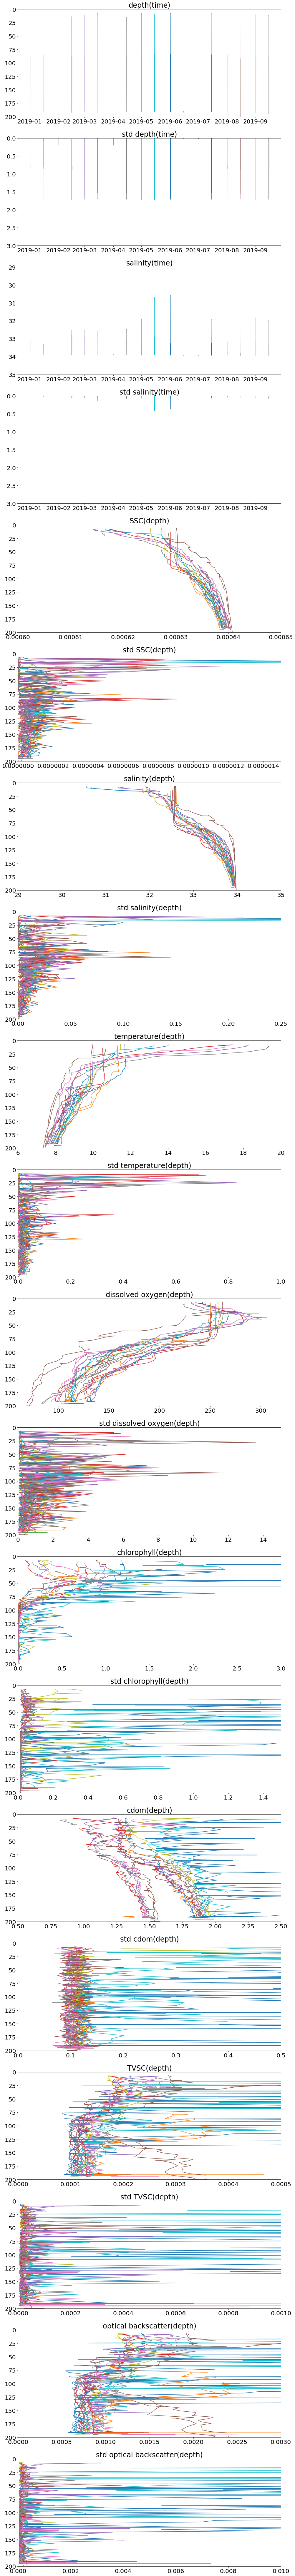

In [10]:
%%time

nplots = 20

p,a = plt.subplots(nplots, 1, figsize=(16,nplots*8))

a[0].set(ylim = (200., 0.), title='depth(time)')
a[2].set(ylim = (35., 29.), title='salinity(time)')
a[4].set(ylim = (200., 0.), xlim = ( 0.0006, 0.00065), title='SSC(depth)')
a[6].set(ylim = (200., 0.), xlim = (29.    , 35.    ), title='salinity(depth)')
a[8].set(ylim = (200., 0.), xlim = ( 6.    , 20.    ), title='temperature(depth)')
a[10].set(ylim = (200., 0.), xlim = (60.    , 320.   ), title='dissolved oxygen(depth)')
a[12].set(ylim = (200., 0.), xlim = ( 0.    , 3.     ), title='chlorophyll(depth)')
a[14].set(ylim = (200., 0.), xlim = ( 0.5   , 2.5    ), title='cdom(depth)')
a[16].set(ylim = (200., 0.), xlim = ( 0.0   , 0.0005 ), title='TVSC(depth)')
a[18].set(ylim = (200., 0.), xlim = ( 0.0   , 0.003  ), title='optical backscatter(depth)')

a[1].set( ylim = (  3., 0.),                                title='std depth(time)')
a[3].set( ylim = (  3., 0.),                                title='std salinity(time)')
a[5].set( ylim = (200., 0.), xlim = ( 0.0    ,  0.0000015), title='std SSC(depth)')
a[7].set( ylim = (200., 0.), xlim = ( 0.0    ,  0.25     ), title='std salinity(depth)')
a[9].set( ylim = (200., 0.), xlim = ( 0.0    ,  1.0      ), title='std temperature(depth)')
a[11].set(ylim = (200., 0.), xlim = ( 0.0    , 15.       ), title='std dissolved oxygen(depth)')
a[13].set(ylim = (200., 0.), xlim = ( 0.0    ,  1.5      ), title='std chlorophyll(depth)')
a[15].set(ylim = (200., 0.), xlim = ( 0.0    , .50       ), title='std cdom(depth)')
a[17].set(ylim = (200., 0.), xlim = ( 0.0    , 0.001     ), title='std TVSC(depth)')
a[19].set(ylim = (200., 0.), xlim = ( 0.0    , 0.01      ), title='std optical backscatter(depth)')

for monthstring in ['01', '02', '03', '04', '05', '06', '07', '08', '09']:
    for daystring in ['01', '15']:
        datestring0 = '2019-' + monthstring + '-' + daystring + 'T08:30' 
        datestring1 = '2019-' + monthstring + '-' + daystring + 'T11:50' 
        ds1 = ds_mean.sel(time=slice(datestring0, datestring1))
        a[0].plot(ds1.time.values, ds1.seawater_pressure)
        a[2].plot(ds1.time.values, ds1.practical_salinity)
        a[4].plot(ds1.seawater_scattering_coefficient, ds1.seawater_pressure)
        a[6].plot(ds1.practical_salinity, ds1.seawater_pressure)
        a[8].plot(ds1.seawater_temperature, ds1.seawater_pressure)
        a[10].plot(ds1.corrected_dissolved_oxygen, ds1.seawater_pressure)
        a[12].plot(ds1.fluorometric_chlorophyll_a, ds1.seawater_pressure)
        a[14].plot(ds1.fluorometric_cdom, ds1.seawater_pressure)
        a[16].plot(ds1.total_volume_scattering_coefficient, ds1.seawater_pressure)
        a[18].plot(ds1.optical_backscatter, ds1.seawater_pressure)
        
        ds2 = ds_std.sel(time=slice(datestring0, datestring1))
        a[1].plot(ds2.time.values, ds2.seawater_pressure)
        a[3].plot(ds2.time.values, ds2.practical_salinity)
        a[5].plot(ds2.seawater_scattering_coefficient, ds1.seawater_pressure)
        a[7].plot(ds2.practical_salinity, ds1.seawater_pressure)
        a[9].plot(ds2.seawater_temperature, ds1.seawater_pressure)
        a[11].plot(ds2.corrected_dissolved_oxygen, ds1.seawater_pressure)
        a[13].plot(ds2.fluorometric_chlorophyll_a, ds1.seawater_pressure)
        a[15].plot(ds2.fluorometric_cdom, ds1.seawater_pressure)
        a[17].plot(ds2.total_volume_scattering_coefficient, ds1.seawater_pressure)
        a[19].plot(ds2.optical_backscatter, ds1.seawater_pressure)
        
        

In [ ]:
%%time

nplots = 12
p,a = plt.subplots(12, 1, figsize=(10,nplots*6))

lim_salinity_lo,    lim_salinity_hi    = 29.5, 34.5
lim_temperature_lo, lim_temperature_hi =  6.,  20.
lim_do_lo,          lim_do_hi          =  0.,  100.
lim_chlor_lo,       lim_chlor_hi       = -0.2,  1.5
lim_cdom_lo,        lim_cdom_hi        =  0.,   1.8
lim_backscatt_lo,   lim_backscatt_hi   =  0.,   0.004

a[10].scatter(ds1.time,             ds.salinity,                                     color='b',               marker='o', s=36.)
a[11].scatter(time,             sample_count,                              color='r',               marker='o', s=36.)

a[0].set(ylim = (250., 0.), xlim = (lim_salinity_lo, lim_salinity_hi),               title='salinity distribution with depth')
a[1].set(ylim = (250., 0.), xlim = (lim_temperature_lo, lim_temperature_hi),         title='temperature distribution with depth')
a[2].set(ylim = (250., 0.), xlim = (lim_chlor_lo, lim_chlor_hi),                     title='chlorophyll distribution with depth')
a[3].set(ylim = (250., 0.), xlim = (lim_cdom_lo, lim_cdom_hi),                       title='cdom distribution with depth')
a[4].set(ylim = (250., 0.), xlim = (lim_backscatt_lo, lim_backscatt_hi),             title='backscatter distribution with depth')
a[5].set(ylim = (lim_salinity_lo, lim_salinity_hi),                                  title='salinity distribution with time')
a[6].set(ylim = (lim_temperature_lo, lim_temperature_hi),                            title='temperature distribution with time')
a[7].set(ylim = (lim_chlor_lo, lim_chlor_hi),                                        title='chlorophyll distribution with time')
a[8].set(ylim = (lim_cdom_lo, lim_cdom_hi),                                          title='cdom distribution with time')
a[9].set(ylim = (lim_backscatt_lo, lim_backscatt_hi),                                title='backscatter distribution with time')
a[10].set(ylim=(250., 0.), xlim = (time[0] - td64(1, 'D'), time[-1] + td64(1, 'D')), title='Distribution of depths with time')
a[11].set(xlim = (time[0] - td64(1, 'D'), time[-1] + td64(1, 'D')),                  title='Distribution of sample counts with time')

# a[0].plot(modis_da_chlor.time, modis_da_chlor, color='r', marker='D', markersize = 9., linestyle='dashed')

## Some 'where next?'


Obviously these data are noisier towards the surface and some are ridiculously noisy. The next 
step needed is to filter on standard deviation, say using a threshold, to determine if throwing 
out a certain amount of the clutter leaves a signal of interest. The fluorometer is particularly
troublesome. 


Meanwhile it will be interesting to revisit curtain plots now that we are at one minute intervals. 


There is also the notion of reducing depth profiles to simple metrics.

... ideas ...


* profile start, peak, end times
* platform residence: start and end times (from profile times)


* (smoothed) chlorophyll derivative, curvature, rate of curvature
* Similarly salinity seems to go through a consistent double-zero in rate of curvature

* intersection depth as used in TDR; for example for temperature or salinity
  * extrapolate smoothed pressure by backing off the derivative change
  * extrapolate platform, intersect

* time of day / sun angle
* local time
* rate of ascent verify; I think 300 cm / minute


In [11]:
ds_mean

<xarray.Dataset>
Dimensions:                              (time: 388482)
Coordinates:
  * time                                 (time) datetime64[ns] 2019-01-01 ... 2019-09-27T18:41:00
Data variables:
    seawater_temperature                 (time) float64 ...
    seawater_pressure                    (time) float64 ...
    practical_salinity                   (time) float64 ...
    corrected_dissolved_oxygen           (time) float64 ...
    density                              (time) float64 ...
    fluorometric_chlorophyll_a           (time) float64 ...
    fluorometric_cdom                    (time) float64 ...
    total_volume_scattering_coefficient  (time) float64 ...
    seawater_scattering_coefficient      (time) float64 ...
    optical_backscatter                  (time) float64 ...

CPU times: user 1.32 s, sys: 121 ms, total: 1.44 s
Wall time: 1.2 s


[(100.0, 0.0), (737272.0, 737330.0)]

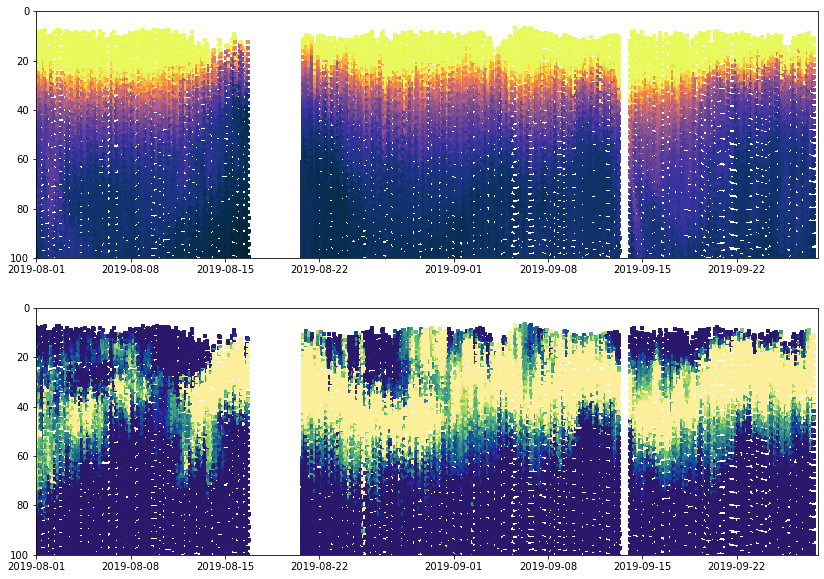

In [53]:
%%time

# Was 10 minutes at full resolution prior to resample

# ['thermal', 'haline', 'solar', 'ice', ...]


t0 = dt64('2019-08-01T00:00')                
t1 = dt64('2019-09-28T00:00')

nPlots = 2
plt.rcParams.update({'font.size': 10})

norm_temp = mplcolors.Normalize(vmin=8.,vmax=14.)
norm_chlor = mplcolors.Normalize(vmin=0.3,vmax=0.6)

p,a=plt.subplots(nPlots, 1, figsize=(14,5*nPlots))

a[0].scatter(ds_mean.time.values, ds_mean.seawater_pressure, cmap=cmocean.cm.thermal, c=ds_mean.seawater_temperature, \
             marker= ',', s = 9.0, norm=norm_temp)
a[1].scatter(ds_mean.time.values, ds_mean.seawater_pressure, cmap=cmocean.cm.haline, c=ds_mean.fluorometric_chlorophyll_a, \
             marker= ',', s = 9.0, norm=norm_chlor)

a[0].set(ylim=(100., 0.0), xlim = (t0, t1))
a[1].set(ylim=(100., 0.0), xlim = (t0, t1))

CPU times: user 1.29 s, sys: 146 ms, total: 1.43 s
Wall time: 1.19 s


[(100.0, 0.0), (737211.0, 737272.0)]

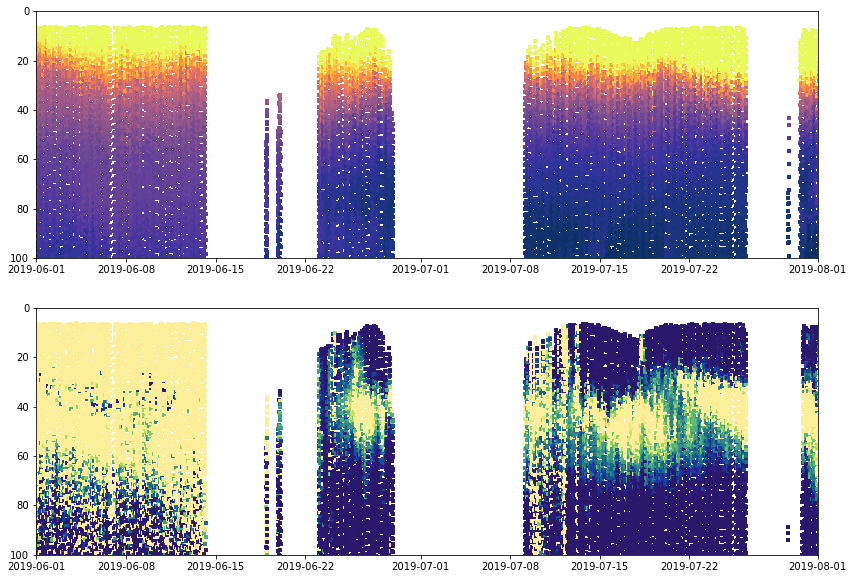

In [54]:
%%time

# Was 10 minutes at full resolution prior to resample

# ['thermal', 'haline', 'solar', 'ice', ...]


t0 = dt64('2019-06-01T00:00')                
t1 = dt64('2019-08-01T00:00')

nPlots = 2
plt.rcParams.update({'font.size': 10})

norm_temp = mplcolors.Normalize(vmin=8.,vmax=14.)
norm_chlor = mplcolors.Normalize(vmin=0.3,vmax=0.6)

p,a=plt.subplots(nPlots, 1, figsize=(14,5*nPlots))

a[0].scatter(ds_mean.time.values, ds_mean.seawater_pressure, cmap=cmocean.cm.thermal, c=ds_mean.seawater_temperature, \
             marker= ',', s = 9.0, norm=norm_temp)
a[1].scatter(ds_mean.time.values, ds_mean.seawater_pressure, cmap=cmocean.cm.haline, c=ds_mean.fluorometric_chlorophyll_a, \
             marker= ',', s = 9.0, norm=norm_chlor)

a[0].set(ylim=(100., 0.0), xlim = (t0, t1))
a[1].set(ylim=(100., 0.0), xlim = (t0, t1))

## Oregon Slope Base Shallow Profiler near-surface comparison to MODIS

The Oregon Slope Base site has a depth of about 2900 meters and is located at the base of the continental shelf 
west of Oregon. The fluorometer data are collected over the course of a day as nine profile runs from a depth
of 200 meters to near the surface. Between profiles that profiler pod is at rest on a platform that is always
at a depth of 200 meters. The sampling rate is a little less than on sample per second. 


The objective in this section is to create an approximate record of near-surface chlorophyll (all measurements 
above say 25 meter depth) and compare that with the MODIS values for the same site. 

In [ ]:
ds_flort.dims

## Conversion: doy from datetime64 and datetime64 from (year + doy)

In [51]:
print('As dates: The 2019 data has start:', ds_mean.time[0].values, 'to end:', ds_mean.time[-1].values)
      
      
# Note use of .values to get the actual datetime64 from the time coordinate
doy0 = doy(ds_mean.time[0].values)
doy1 = doy(ds_mean.time[-1].values)
print('\nThis dataset runs from day', doy0, 'to day', doy1, 'for a span in days of', doy1 - doy0 + 1)

# Make sure 1-JAN works out properly in the other direction
print("\nThe date corresponding to 2019 doy = 1 is", dt64_from_doy(2019, 1))

inter_sample_time = (ds_mean.time[1].values - ds_mean.time[0].values)/td64(1, 's')
print('\nThe time between one-minute (resampled) timestamps is of course', inter_sample_time, 'seconds.')

As dates: The 2019 data has start: 2019-01-01T00:00:00.000000000 to end: 2019-09-27T18:41:00.000000000

This dataset runs from day 1 to day 270 for a span in days of 270

The date corresponding to 2019 doy = 1 is 2019-01-01

The time between one-minute (resampled) timestamps is of course 60.0 seconds.


## Early work on SP Fluorometer data reduction (summer 2019 only)

***Hey seriously look at salinity and picture a chart of the second derivative of a filtered version. That chart will cross zero twice and the zero crossings could be seen as a characterization of the upper layer.***

In [ ]:
###########################
# 
# Shallow profiler data reduction
# 
# From time series we would like to progress to time-block values, for example considering six-day
#   blocks of time throughout the year. There are three criteria for creating a value for some 
#   sensor parameter such as chlorophyll-a: There are samples in a depth range and in a time range;
#   and the mean of these values is substantial when compared to their standard deviation.

# operate on rca_ds_chlor to extract values for a year: Average by week and depth
doy = 164                 # one would eventually make this 0
doy_end = 257             # one would eventually make this 365
year = 2019
depth_start, depth_end, depth_delta = 0., 260.1, 10.
time_interval_days = 1     # even makes the "center of interval" simpler

time = []
depth = []
sample_count = []
salinity = []
temperature = []
chlor = []
cdom = []
backscatt = []

lim_temperature_ignore = 2.0
lim_salinity_ignore    = 1.0
lim_chlor_ignore       = 0.6
lim_cdom_ignore        = 0.8
lim_backscatt_ignore   = 0.0015

while doy < doy_end:
    
    print('day of year', doy)

    time_range_start = dt64(str(year) + '-01-01') + td64(doy, 'D')
    time_range_end   = dt64(str(year) + '-01-01') + td64(doy + time_interval_days, 'D')    
    this_time        = dt64(str(year) + '-01-01') + td64(doy + time_interval_days//2, 'D')
    
    ds1 = rca_ds_chlor.sel(time = slice(time_range_start, time_range_end))
    
    for d in np.arange(depth_start, depth_end, depth_delta): 
        
        this_depth = d + depth_delta/2.
        
        ds2 = ds1.where(ds1.int_ctd_pressure <  d + depth_delta, drop=True)
        ds3 = ds2.where(ds2.int_ctd_pressure >= d,               drop=True)

        nSamples = ds3.dims['time']
        sample_count.append(nSamples)     
        depth.append(this_depth)
        time.append(this_time)  
            
        if nSamples > 1:
   
            param_mean = ds3.practical_salinity.values.mean()
            param_std = ds3.practical_salinity.values.std()
            if param_std < lim_salinity_ignore: salinity.append((param_mean, param_std, this_depth, this_time, nSamples))
                
            param_mean = ds3.seawater_temperature.values.mean()
            param_std = ds3.seawater_temperature.values.std()
            if param_std < lim_temperature_ignore: temperature.append((param_mean, param_std, this_depth, this_time, nSamples))

            param_mean = ds3.fluorometric_chlorophyll_a.values.mean()
            param_std = ds3.fluorometric_chlorophyll_a.values.std()
            if param_std < lim_chlor_ignore: chlor.append((param_mean, param_std, this_depth, this_time, nSamples))
                
            param_mean = ds3.fluorometric_cdom.values.mean()
            param_std = ds3.fluorometric_cdom.values.std()
            if param_std < lim_cdom_ignore: cdom.append((param_mean, param_std, this_depth, this_time, nSamples))

            param_mean = ds3.optical_backscatter.values.mean()
            param_std = ds3.optical_backscatter.values.std()
            if param_std < lim_backscatt_ignore: backscatt.append((param_mean, param_std, this_depth, this_time, nSamples))
        
        else:
            salinity.append((np.nan, np.nan, this_depth, this_time))
            temperature.append((np.nan, np.nan, this_depth, this_time))
            chlor.append((np.nan, np.nan, this_depth, this_time))
            cdom.append((np.nan, np.nan, this_depth, this_time))
            backscatt.append((np.nan, np.nan, this_depth, this_time))

    # increment the day of year by one week
    doy += time_interval_days

In [ ]:
%%time

nplots = 12
p,a = plt.subplots(12, 1, figsize=(10,nplots*6))

# plt.rcParams.update({'font.size': 14})

salinity_mean, salinity_std, salinity_depth, salinity_time             = zip(*salinity)
temperature_mean, temperature_std, temperature_depth, temperature_time = zip(*temperature)
chlor_mean, chlor_std, chlor_depth, chlor_time                         = zip(*chlor)
cdom_mean, cdom_std, cdom_depth, cdom_time                             = zip(*cdom)
backscatt_mean, backscatt_std, backscatt_depth, backscatt_time         = zip(*backscatt)

lim_salinity_lo,    lim_salinity_hi    = 29.5, 34.5
lim_temperature_lo, lim_temperature_hi =  6.,  20.
lim_chlor_lo,       lim_chlor_hi       = -0.2,  1.5
lim_cdom_lo,        lim_cdom_hi        =  0.,   1.8
lim_backscatt_lo,   lim_backscatt_hi   =  0.,   0.004

a[0].errorbar(salinity_mean,    salinity_depth,    xerr = salinity_std,    color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[1].errorbar(temperature_mean, temperature_depth, xerr = temperature_std, color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[2].errorbar(chlor_mean,       chlor_depth,       xerr = chlor_std,       color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[3].errorbar(cdom_mean,        cdom_depth,        xerr = cdom_std,        color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[4].errorbar(backscatt_mean,   backscatt_depth,   xerr = backscatt_std,   color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[5].errorbar(salinity_time,    salinity_mean,     yerr = salinity_std,    color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[6].errorbar(temperature_time, temperature_mean,  yerr = temperature_std, color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[7].errorbar(chlor_time,       chlor_mean,        yerr = chlor_std,       color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[8].errorbar(cdom_time,        cdom_mean,         yerr = cdom_std,        color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[9].errorbar(backscatt_time,   backscatt_mean,    yerr = backscatt_std,   color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[10].scatter(time,             depth,                                     color='b',               marker='o', s=36.)
a[11].scatter(time,             sample_count,                              color='r',               marker='o', s=36.)

a[0].set(ylim = (250., 0.), xlim = (lim_salinity_lo, lim_salinity_hi),               title='salinity distribution with depth')
a[1].set(ylim = (250., 0.), xlim = (lim_temperature_lo, lim_temperature_hi),         title='temperature distribution with depth')
a[2].set(ylim = (250., 0.), xlim = (lim_chlor_lo, lim_chlor_hi),                     title='chlorophyll distribution with depth')
a[3].set(ylim = (250., 0.), xlim = (lim_cdom_lo, lim_cdom_hi),                       title='cdom distribution with depth')
a[4].set(ylim = (250., 0.), xlim = (lim_backscatt_lo, lim_backscatt_hi),             title='backscatter distribution with depth')
a[5].set(ylim = (lim_salinity_lo, lim_salinity_hi),                                  title='salinity distribution with time')
a[6].set(ylim = (lim_temperature_lo, lim_temperature_hi),                            title='temperature distribution with time')
a[7].set(ylim = (lim_chlor_lo, lim_chlor_hi),                                        title='chlorophyll distribution with time')
a[8].set(ylim = (lim_cdom_lo, lim_cdom_hi),                                          title='cdom distribution with time')
a[9].set(ylim = (lim_backscatt_lo, lim_backscatt_hi),                                title='backscatter distribution with time')
a[10].set(ylim=(250., 0.), xlim = (time[0] - td64(1, 'D'), time[-1] + td64(1, 'D')), title='Distribution of depths with time')
a[11].set(xlim = (time[0] - td64(1, 'D'), time[-1] + td64(1, 'D')),                  title='Distribution of sample counts with time')

# a[0].plot(modis_da_chlor.time, modis_da_chlor, color='r', marker='D', markersize = 9., linestyle='dashed')

## one-day resolution

In [ ]:
%%time

nplots = 12
p,a = plt.subplots(12, 1, figsize=(10,nplots*6))

# plt.rcParams.update({'font.size': 14})

salinity_mean, salinity_std, salinity_depth, salinity_time             = zip(*salinity)
temperature_mean, temperature_std, temperature_depth, temperature_time = zip(*temperature)
chlor_mean, chlor_std, chlor_depth, chlor_time                         = zip(*chlor)
cdom_mean, cdom_std, cdom_depth, cdom_time                             = zip(*cdom)
backscatt_mean, backscatt_std, backscatt_depth, backscatt_time         = zip(*backscatt)

lim_salinity_lo,    lim_salinity_hi    = 29.5, 34.5
lim_temperature_lo, lim_temperature_hi =  6.,  20.
lim_chlor_lo,       lim_chlor_hi       = -0.2,  1.5
lim_cdom_lo,        lim_cdom_hi        =  0.,   1.8
lim_backscatt_lo,   lim_backscatt_hi   =  0.,   0.004

a[0].errorbar(salinity_mean,    salinity_depth,    xerr = salinity_std,    color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[1].errorbar(temperature_mean, temperature_depth, xerr = temperature_std, color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[2].errorbar(chlor_mean,       chlor_depth,       xerr = chlor_std,       color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[3].errorbar(cdom_mean,        cdom_depth,        xerr = cdom_std,        color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[4].errorbar(backscatt_mean,   backscatt_depth,   xerr = backscatt_std,   color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[5].errorbar(salinity_time,    salinity_mean,     yerr = salinity_std,    color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[6].errorbar(temperature_time, temperature_mean,  yerr = temperature_std, color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[7].errorbar(chlor_time,       chlor_mean,        yerr = chlor_std,       color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[8].errorbar(cdom_time,        cdom_mean,         yerr = cdom_std,        color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[9].errorbar(backscatt_time,   backscatt_mean,    yerr = backscatt_std,   color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[10].scatter(time,             depth,                                     color='b',               marker='o', s=36.)
a[11].scatter(time,             sample_count,                              color='r',               marker='o', s=36.)

a[0].set(ylim = (250., 0.), xlim = (lim_salinity_lo, lim_salinity_hi),               title='salinity distribution with depth')
a[1].set(ylim = (250., 0.), xlim = (lim_temperature_lo, lim_temperature_hi),         title='temperature distribution with depth')
a[2].set(ylim = (250., 0.), xlim = (lim_chlor_lo, lim_chlor_hi),                     title='chlorophyll distribution with depth')
a[3].set(ylim = (250., 0.), xlim = (lim_cdom_lo, lim_cdom_hi),                       title='cdom distribution with depth')
a[4].set(ylim = (250., 0.), xlim = (lim_backscatt_lo, lim_backscatt_hi),             title='backscatter distribution with depth')
a[5].set(ylim = (lim_salinity_lo, lim_salinity_hi),                                  title='salinity distribution with time')
a[6].set(ylim = (lim_temperature_lo, lim_temperature_hi),                            title='temperature distribution with time')
a[7].set(ylim = (lim_chlor_lo, lim_chlor_hi),                                        title='chlorophyll distribution with time')
a[8].set(ylim = (lim_cdom_lo, lim_cdom_hi),                                          title='cdom distribution with time')
a[9].set(ylim = (lim_backscatt_lo, lim_backscatt_hi),                                title='backscatter distribution with time')
a[10].set(ylim=(250., 0.), xlim = (time[0] - td64(1, 'D'), time[-1] + td64(1, 'D')), title='Distribution of depths with time')
a[11].set(xlim = (time[0] - td64(1, 'D'), time[-1] + td64(1, 'D')),                  title='Distribution of sample counts with time')

# a[0].plot(modis_da_chlor.time, modis_da_chlor, color='r', marker='D', markersize = 9., linestyle='dashed')

In [ ]:
print(len(chlor))
print((256-164)*26)
print(chlor[438])

## Using .rolling().mean() to smooth a signal

In [ ]:
# rca_subda_chlor_rolling_mean = rca_subds_chlor.fluorometric_chlorophyll_a.rolling(time=600, center=True).mean()

# minima version
# rca_subda_chlor_rolling_min = rca_subds_chlor.fluorometric_chlorophyll_a.rolling(time=600).min()

## Chart: MODIS and SP-surface chlorophyll superimposed

In [ ]:
%%time

p,a = plt.subplots(3, 1, figsize=(12,18))
plt.rcParams.update({'font.size': 14})

# alternative: use .plot(): a[0].plot(rca_subda_time, rca_subda_chlor_rolling_mean, color='b')
a[0].scatter(rca_subda_time.values, rca_subda_chlor_rolling_mean, color='b', marker= 'o', s = 4.0)
a[1].scatter(rca_subda_chlor_rolling_mean, rca_subda_pressure, color='k', marker= ',', s = 1.0) 
a[2].scatter(rca_subda_time.values, rca_subda_pressure, color='b', marker=',', s=1.0) 

a[0].set(ylim=(0., 1.5), xlim = (t0, t1), \
         title='OSB Chlorophyll (Summer 2019) \n MODIS (red) vs shallow profiler at surface')
a[1].set(ylim=(30., 0.), xlim = (0., 3.), title='shallow profiler: chlorophyll (x axis) vs pressure')
a[2].set(ylim=(30., 0.), xlim = (t0, short_time), title='shallow profiler: time (x axis) vs pressure')

a[0].plot(modis_da_chlor.time, modis_da_chlor, color='r', marker='D', markersize = 9., linestyle='dashed')
# a[0].scatter(np.datetime(modis_da_chlor.time), modis_da_chlor, color='r', marker= ',', s = 36.0)

## Basic exploration of time and Datasets (compression needed)

In [ ]:
rca_ds_chlor

In [ ]:
time_start = dt64('2019-06-14T23:10')
week_timedelta = td64(1,'W')
day_timedelta = td64(1,'D')
hour_timedelta = td64(1,'h')
minute_timedelta = td64(1,'m')
time_end = time_start + minute_timedelta
# print (time_start, week_timedelta, time_end)
# rca_subds_week = rca_ds_chlor.where()

In [ ]:
rca_ds_chlor.time

In [ ]:

minute_data = rca_ds_chlor.time.where(rca_ds_chlor.time < time_end)

In [ ]:
# minute_data = rca_ds_chlor.time[:100]
# dict(time=slice(time_start, time_end))]
time0 = dt64('2019-06-14T23:10:19.399109120')
time1 = dt64('2019-06-14T23:12:11.132952064')
# time1 = time0 + day_timedelta

## uses `.loc()` without explanation (needed)

In [ ]:
mySubdataset = rca_ds_chlor.loc[dict(time = slice(time0, time1))]
mySubdataset.dims
# mySubdataset gives the usual full Data variables list

In [ ]:
time0 = dt64('2019-06-23T00')            # a known good start time
time1 = time0 + td64(24, 'h')            # 20 hours later; a good time range

rca_subds_chlor = rca_ds_chlor.sel(time = slice(time0, time1))
# print(rca_subds_chlor)

In [ ]:
rca_subds_chlor_depth = rca_subds_chlor.where(rca_subds_chlor.int_ctd_pressure <= 50., drop=True)
rca_subds_chlor_depth2 = rca_subds_chlor_depth.where(rca_subds_chlor_depth.int_ctd_pressure > 40., drop=True)

# one UTC day, 24 hours, 10 meter depth range 40 to 50 meters: 3094 values
rca_reference = []

rca_reference.append(rca_subds_chlor_depth2.fluorometric_chlorophyll_a.values.mean())
rca_reference.append(rca_subds_chlor_depth2.fluorometric_chlorophyll_a.values.std())
rca_reference.append(rca_subds_chlor_depth2.fluorometric_cdom.values.mean())
rca_reference.append(rca_subds_chlor_depth2.fluorometric_cdom.values.std())
rca_reference.append(rca_subds_chlor_depth2.total_volume_scattering_coefficient.values.mean())
rca_reference.append(rca_subds_chlor_depth2.total_volume_scattering_coefficient.values.std())
rca_reference.append(rca_subds_chlor_depth2.seawater_temperature.values.mean())
rca_reference.append(rca_subds_chlor_depth2.seawater_temperature.values.std())
rca_reference.append(rca_subds_chlor_depth2.practical_salinity.values.mean())
rca_reference.append(rca_subds_chlor_depth2.practical_salinity.values.std())
rca_reference.append(rca_subds_chlor_depth2.seawater_scattering_coefficient.values.mean())
rca_reference.append(rca_subds_chlor_depth2.seawater_scattering_coefficient.values.std())
rca_reference.append(rca_subds_chlor_depth2.optical_backscatter.values.mean())
rca_reference.append(rca_subds_chlor_depth2.optical_backscatter.values.std())

rca_reference

In [ ]:
print(rca_subds_chlor.time[0], rca_subds_chlor.time[-1])

In [ ]:
this_check = []

this_check.append(rca_subds_chlor_depth2.fluorometric_chlorophyll_a.values.mean())
this_check.append(rca_subds_chlor_depth2.fluorometric_chlorophyll_a.values.std())
this_check.append(rca_subds_chlor_depth2.fluorometric_cdom.values.mean())
this_check.append(rca_subds_chlor_depth2.fluorometric_cdom.values.std())
this_check.append(rca_subds_chlor_depth2.total_volume_scattering_coefficient.values.mean())
this_check.append(rca_subds_chlor_depth2.total_volume_scattering_coefficient.values.std())
this_check.append(rca_subds_chlor_depth2.seawater_temperature.values.mean())
this_check.append(rca_subds_chlor_depth2.seawater_temperature.values.std())
this_check.append(rca_subds_chlor_depth2.practical_salinity.values.mean())
this_check.append(rca_subds_chlor_depth2.practical_salinity.values.std())
this_check.append(rca_subds_chlor_depth2.seawater_scattering_coefficient.values.mean())
this_check.append(rca_subds_chlor_depth2.seawater_scattering_coefficient.values.std())
this_check.append(rca_subds_chlor_depth2.optical_backscatter.values.mean())
this_check.append(rca_subds_chlor_depth2.optical_backscatter.values.std())


test_result = [0.3604830856472429,
               0.1919204481891048,
               1.0962848650762613,
               0.17839049820310146,
               0.0008212006132186154,
               0.00204944404433351,
               10.024135745630813,
               0.5840680323759343,
               32.457901950062556,
               0.0374061403722503,
               0.0006297161117352217,
               1.205469921244279e-06,
               0.005532910531591812,
               0.013855694492444818]

In [ ]:
rca_subds_chlor_depth2

In [ ]:
rca_subds_chlor_depth2

In [ ]:
rca_subds_chlor_depth2.int_ctd_pressure.plot()

In [ ]:
rca_subds_chlor.int_ctd_pressure[:20].values

In [ ]:
# rca_subds_chlor_pressure = rca_subds_chlor.filter_by_attrs(
# where(int_ctd_pressure < 100., drop=True)
rca_subds_chlor_pressure = rca_subds_chlor.reset_coords(int_ctd_pressure)

In [ ]:
rca_subds_chlor_pressure.int_ctd_pressure.plot()

In [ ]:
rca_ds_chlor

## Curtain plots of several profiler sensors

Incomplete: Missing are the lower charts and an automated range calculation.

From this point we use another boolean switch to skip over the subsequent charts (some of which take a while).

In [ ]:
%%time

# Expect about 10 minutes for this to run: At full resolution (see to do list)

# ['thermal',
#  'haline',
#  'solar',
#  'ice',
#  'gray',
#  'oxy',
#  'deep',
#  'dense',
#  'algae',
#  'matter',
#  'turbid',
#  'speed',
#  'amp',
#  'tempo',
#  'rain',
#  'phase',
#  'topo',
#  'balance',
#  'delta',
#  'curl',
#  'diff',
#  'tarn']

t0 = dt64('2019-07-10T00:00')                
t1 = dt64('2019-07-11T00:00')

#     pressure    = ds.int_ctd_pressure
#     time_x_axis = ds.time
#     chlor       = ds.fluorometric_chlorophyll_a
#     cdom        = ds.fluorometric_cdom
#     volscat     = ds.total_volume_scattering_coefficient
#     temp        = ds.seawater_temperature
#     salinity    = ds.practical_salinity
#     seascat     = ds.seawater_scattering_coefficient
#     optiback    = ds.optical_backscatter

nPlots = 2
plt.rcParams.update({'font.size': 10})
p,a=plt.subplots(nPlots, 1, figsize=(20,7*nPlots))

# norm = mplcolors.Normalize(vmin=0.0,vmax=0.7)
# removed norm = norm...
aindex = 0
a[aindex].scatter(time_x_axis.values, pressure, cmap=cmocean.cm.algae, c=chlor, marker= ',', s = 1.0)
a[aindex].set(ylim=(200., 0.0), xlim = (t0, t1))


#     plt.rcParams.update({'font.size': 14})
#     a[aindex].set(title='Chlorophyll with time and depth')
#     plt.rcParams.update({'font.size': 10})
#     a[aindex].set_ylabel('Pressure (dbar)')
#     a[aindex].set_xlabel('Date')

#     aindex = 1
#     norm = mplcolors.Normalize(vmin=7.0,vmax=14.)
#     a[aindex].scatter(time_x_axis.values, pressure, cmap=cmocean.cm.oxy, c=temp, norm=norm, marker= ',', s = 1.0)
#     a[aindex].set(ylim=(200., 0.0), xlim = (t0, t1))
#     plt.rcParams.update({'font.size': 14})
#     a[aindex].set(title='Temperature with time and depth')
#     plt.rcParams.update({'font.size': 10})
#     a[aindex].set_ylabel('Pressure (dbar)')
#     a[aindex].set_xlabel('Date')

#     aindex = 2
#     norm = mplcolors.Normalize(vmin=7.0,vmax=14.)
#     a[aindex].scatter(time_x_axis.values, pressure, cmap=cmocean.cm.oxy, c=optiback, norm=norm, marker= ',', s = 1.0)
#     a[aindex].set(ylim=(200., 0.0), xlim = (t0, t1))
#     plt.rcParams.update({'font.size': 14})
#     a[aindex].set(title='Optical backscatter with time and depth')
#     plt.rcParams.update({'font.size': 10})
#     a[aindex].set_ylabel('Pressure (dbar)')
#     a[aindex].set_xlabel('Date')

#     aindex = 3
#     norm = mplcolors.Normalize(vmin=7.0,vmax=14.)
#     a[aindex].scatter(time_x_axis.values, pressure, cmap=cmocean.cm.oxy, c=salinity, norm=norm, marker= ',', s = 1.0)
#     a[aindex].set(ylim=(200., 0.0), xlim = (t0, t1))
#     plt.rcParams.update({'font.size': 14})
#     a[aindex].set(title='Salinity with time and depth')
#     plt.rcParams.update({'font.size': 10})
#     a[aindex].set_ylabel('Pressure (dbar)')
#     a[aindex].set_xlabel('Date')

## Expanded chlorophyll curtain plots

Treats the below-100-meters and above-100-meters as two separate colormap tasks. 

In [ ]:
%%time

# Re-do these from the resampled data

from matplotlib import colors as mplcolors

if doShallowProfilerChlorophyllCharts:

    t0 = dt64('2019-06-01T00:00')                
    t1 = dt64('2019-09-01T00:00')

    pressure = ds.int_ctd_pressure
    time_x_axis = ds.time
    chlor = ds.fluorometric_chlorophyll_a


    plt.rcParams.update({'font.size': 10})
    p,a=plt.subplots(2, 1, figsize=(14,14))

    norm = mplcolors.Normalize(vmin=0.0,vmax=0.5)
    a[0].scatter(time_x_axis.values, pressure, cmap='jet', c=chlor, norm=norm, marker= ',', s = 1.0)
    a[0].set(ylim=(100., 0.0), xlim = (t0, t1))
    plt.rcParams.update({'font.size': 14})
    a[0].set(title='Chlorophyll with time and depth')
    plt.rcParams.update({'font.size': 10})
    a[0].set_ylabel('Pressure (dbar)')
    a[0].set_xlabel('Date')

    norm = mplcolors.Normalize(vmin=0.0,vmax=0.1)
    a[1].scatter(time_x_axis.values, pressure, cmap='jet', c=chlor, norm=norm, marker= ',', s = 1.0)
    a[1].set(ylim=(200., 100.0), xlim = (t0, t1))
    plt.rcParams.update({'font.size': 14})
    a[1].set(title='Chlorophyll with time and depth')
    plt.rcParams.update({'font.size': 10})
    a[1].set_ylabel('Pressure (dbar)')
    a[1].set_xlabel('Date')

## Double chlorophyll lens July 20 2019 (3 profiles) 

We can ask whether the recorded signal is a mirror image as the profiler rises and falls. To see this
it helps to have a double-y-axis as shown in [this example](https://matplotlib.org/gallery/api/two_scales.html). 


Below we have three consecutive profiles over the course of seven hours which all demonstrate a double-maximum
in chlorophyll concentration: One at about 30 meters and another at about 55 meters. 

In [ ]:
# 
# Precision section works with precise times versus day-scale
#   The precise times are an experiment in using 2 hours 40 minutes to chop up the 9 profiles in the day in a regular manner...
#   but a better approach would be to detect the profiles and time-box each one individually. 
# 

t0 = dt64('2019-07-20T11:00')
t1 = dt64('2019-07-20T18:00')
dss = ds.sel(time=slice(t0, t1))
len(dss.time)

In [ ]:
p,a=plt.subplots(2, 1, figsize=(14,14))
plt.rcParams.update({'font.size': 10})
chlor_a = dss.fluorometric_chlorophyll_a
chlor_a_min = chlor_a.rolling(time=60, center=True).min()
pressure = dss.int_ctd_pressure

a[0].plot(dss.time, chlor_a_min, color='g')
a[1].scatter(pressure, chlor_a, color='k', marker= 'D', s = 4.0) 

a[0].set(ylim=(0., 0.55), xlim = (t0, t1), title='Shallow profiler: Chlorophyll (green) and pressure (blue) over seven hours')
a[1].set(ylim=(0., 0.8), xlim = (0., 200.), title='Persistent double maximum: Chlorophyll with pressure')

a[0].set_ylabel('Chlorophyll (ug L-1)')
a[0].set_xlabel('Time: July 20 2019, hours 11 - 18')
a[0].tick_params(axis='y', labelcolor='green')

a[1].set_ylabel('Chlorophyll (ug L-1)')
a[1].set_xlabel('Pressure (dbar)')
a[1].tick_params(axis='y', labelcolor='k')

a0p = a[0].twinx()
a0p.set_ylabel('Pressure (dbar)')
a0p.plot(dss.time, pressure, color='blue')
a0p.tick_params(axis='y', labelcolor='blue')
a0p.set(ylim=(200., 0.), title='   ')

# Optional formatting code: p.tight_layout()

## Animating chlorophyll depth profiles

From August 1 to August 15 2019 we have 9 profiles per day of the water column at the Oregon Slope Base site.  
The objective here is to animate these 135 profiles: Depth on the y-axis and chlorophyll concentration on 
the x-axis. Each frame of the animation is a single profile featuring both rise and descent tracks. 

* [JS Animation in Jupyter notebooks 2nd blog post (update to original)](http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/)
* `HTML(anim.to_html5_video())` generates the animation with minimal controls (including download)
* `HTML(anim.to_jshtml())` generates the animation with several playback controls


*ffmpeg* installation is necessary: `conda install -c conda-forge ffmpeg`


##### In both cases I get a static view below the animated one, a bug

##### Steps

1. Define chart parameters
2. Define initialization and animation functions
3. Instantiate an animation object
4. Generate the animation

In [ ]:
doShallowProfilerChlorophyllAnimation = False

if doShallowProfilerChlorophyllAnimation:
    # 1. Chart setup
    fig, ax = plt.subplots(figsize=(7,14))     # creates a vertically elongated chart (7 is width)
    plt.rcParams.update({'font.size': 10})

    ax.set_xlim(( 0., 1.))
    ax.set_ylim((125., 0.))
    ax.tick_params(axis='y', labelcolor='k')
    ax.set_ylabel('Pressure (dbar)', fontsize=16)
    ax.set_xlabel('Chlorophyll (ug L-1)', fontsize=16)
    plt.rcParams.update({'font.size': 14})
    ax.set(title='Time series: \n Chlorophyll (x) with Pressure (y)')
    plt.rcParams.update({'font.size': 10})

    # divides the day up into approximately 9 intervals of 2 hours 40 minutes
    proftime = ['00:00', '02:40', '05:20', '08:00', '10:40', '13:20', '16:00', '18:40', '21:20', '23:59']

    # Each render of the profile chart will try to blank out the prior datetime
    prev_msg = '              '

    # matplotlib plot object assigned to variable 'line' with some interesting syntax 'line,'
    #   ax.plot() returns a tuple with just one element
    #   using 'line,' syntax assigns the first (and only) element of this tuple to 'line'
    #   There are other syntactical alternatives to this economical convention
    #     Equivalent: [line] = ax.plot([], [], lw=3)
    #     Equivalent: line = ax.plot([], [], lw=3)[0]
    line, = ax.plot([], [], lw=3)


# A scatter plot is a more involved proposition than is a basic .plot()
# For example the following does not work:
#   line, = ax.scatter([], [], color='k', marker='D', s = 4.0)


# 2. Initialize and Animation functions

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    global prev_msg
    day = i//9 + 1
    prof = i%9
    if day < 10: day1 = '0' + str(day)
    else: day1 = str(day)
    day2 = day1
    
    # '2019-07-20T11:00'
    t0string = '2019-08-' + day1 + 'T' + proftime[prof]
    t1string = '2019-08-' + day2 + 'T' + proftime[prof+1]    
    t0 = dt64(t0string)
    t1 = dt64(t1string)
    ds_1day = ds.sel(time=slice(t0, t1))

    chlor_a = ds_1day.fluorometric_chlorophyll_a
    chlor_a_min = chlor_a.rolling(time=60, center=True).min()
    pressure = ds_1day.int_ctd_pressure
    
    # ax.scatter(pressure, chlor_a, color='k', marker= 'D', s = 4.0) 

    line.set_data(chlor_a_min, pressure)

    # speculative line of code...
    ax.text(0.5, 120., prev_msg, rotation=0, fontsize=18, color='white', fontweight='bold')
    ax.text(0.5, 120., str(t0), rotation=0, fontsize=18, color='blue', fontweight='bold')
    prev_msg = str(t0)

    return (line,)


if doShallowProfilerChlorophyllAnimation:
    # 3. Instantiate an animation object
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=15*9, interval=100, blit=True)

    # 4. Generate the animated video result
    # simple animation, basic controls
    HTML(anim.to_html5_video())                      
    # second version: various playback controls: 
    # HTML(anim.to_jshtml())

In [ ]:
%%HTML
<video width="50%" controls>
      <source src="./chlorophyll_animation.mp4" type="video/mp4">
</video>

## Regional Cabled Array discrete datatsets

This section concerns data collected during VISIONS cruises. First we have some contextual remarks.
Below this is a markdown translation of a README file.


The cruise is designated AT4212 (AT indicating R/V Atlantis). We have a CSV data file consisting of 79 columns.
A set of adjacent rows corresponds to a single cast; where each row is a Niskin bottle closure. 
At Oregon Slope Base we have 2 casts with respectively 17 and 16 Niskin bottles. 
These were run 250 meters from the location of the Slope Base Shallow Profiler. Times are given in 
UTC as 


* June 14 2019 for the group of 17: 2019-06-14T11:24:21.000Z 
* June 27 2019 for the group of 16: 2019-06-27T19:38:18.000Z 


CSV column listings as follows (where I number from zero); skipping items of less interest:

| idx | contains     | notes     |
| :---- | :--------------------: | -------------------------------------------: |
|  0 | cruise   | always AT4212    |
|  3 | latitude   | dd     |
| 4 | longitude | dd    |
| 4 | start time | UTC    |
| 78 | some carbon flag | last entry  |




#### README file: Cabled-10_AT4212_Discrete_Summary Information:


##### File Mapping

Hex files were renamed from the original ship-provided files for consistency and ease of processing.  
Original file names are listed below on the left, with corresponding new file names on the right.  
Original Hex files are accessible for each cruise in the Cruise Data folder under the “Ship Data” 
sub-directory.  Bottle files used to populate the discrete summary can be found in the Water Sampling 
sub-directory under “Shipboard Data”.


```
at4212001 = AT4212_CTD-001
at4212002 = AT4212_CTD-002
at4212003 = AT4212_CTD-003
at4212004 = AT4212_CTD-004
at4212005 = AT4212_CTD-005
at4212006 = AT4212_CTD-006
at4212007 = AT4212_CTD-007
at4212008 = AT4212_CTD-008
at4212009 = AT4212_CTD-009
at4212010 = AT4212_CTD-010
at4212011 = AT4212_CTD-011
at4212012 = AT4212_CTD-012
at4212013 = AT4212_CTD-013
at4212014 = AT4212_CTD-014
at4212015 = AT4212_CTD-015
J2-1160_20190620_0400 = AT4212_J2-1160_20190619_0500
J2-1161_20190620_0400 = AT4212_J2-1161_20190619_1300
J2-1163_20190620_0400 = AT4212_J2-1163_20190620_0400
```


Summary Notes:


```
AT4212, CTD-001, Cast Flag: “no cast log, bottom depth is approximate”
AT4212, CTD-002, Cast Flag: “no cast log, bottom depth is approximate”
AT4212, CTD-003, Cast Flag: “no cast log, bottom depth is approximate”
AT4212, CTD-004, Cast Flag: “no cast log, bottom depth is approximate”
AT4212, CTD-005, Niskin 11, DIC flag: “too much headspace”
AT4212, CTD-007, Niskin 20, Fluorescence Flag: “Filtering Assy leaked (<50 mL); can’t tell if pre- or post-filter”
AT4212, CTD-008, Cast Flag: “Fire in Engine Room Cause premature cast end after Niskin 16”
AT4212, CTD-008, Niskin 2, Salinity flag: “salt on bottleneck”
AT4212, CTD-008, Niskin 13, Salinity flag: “salt on bottleneck”
AT4212, CTD-010, Niskin 3, Salinity flag: “salt on bottleneck”
AT4212, CTD-013, Niskin 5, Salinity flag: “salt on bottleneck”
AT4212, CTD-015, Cast Flag: “Power loss, cast aborted, location and bottom depth approximate”
```

General File Notes:


* Discrete sample fields containing text or non-decimal numbers (“DIC-###”, “CH-##”, “OX-###”, “SA####”, or “673”) 
list sample bottle numbers and not analyzed data. Bottle numbers are included when data are not yet available, 
and will be replaced with analysis results as data are received from analysis labs. 
* Fill value = -9999999
* Carbon analysis was provided by Burke Hales lab at Oregon State University.  Calculated carbon parameters were 
provided by Hales using custom software routines using published values for the various carbon chemistry constants.  
Hale’s lab provides the following references regarding constants used in the calculations.  For further information, 
please contact Burke Hales (bhales@coas.oregonstate.edu).
* Carbonic acid dissociation constants: Millero (2010), with full resolution constants provided by Millero via private conversation, equal to Lueker’s constants at S > 25).
* Kw: Millero (1995)
* Kb: Dickson (1990)
* Ksp for calcite and aragonite: Mucci (1980)
* Kh: Weiss (1973)
* Alkalnity is modeled as: HCO3- + 2CO3= + B(OH)4- + OH- - H+

## Cast data

We now turn to the discrete sample data. The objective is to
compare two casts with coincident shallow profiler data. 

In [ ]:
casts = pd.read_csv('ctdcasts_visions2019.csv')       # this will be a pandas DataFrame

In [ ]:
print(type(casts))
print()
print(type(casts.columns))    # An Index, i.e. an immutable ndarray implementing an ordered, sliceable set. 
                              #   Also: The basic object storing axis labels for all pandas objects.
                              #   (indexing as a verb in pandas means data subsetting)
print()
print(casts.shape)            # gives 272 rows, 79 columns
print()

# This is a very entertaining thing to do (list methods/attributes): 
# g.dirnou(casts)

# This lists the column headers starting with Cruise and Station
for header in casts.columns[0:6]: print(header)

In [ ]:
# print(casts['Station'][17:36]) # 18 - 34 inclusive
# print(casts['Station'][67:85]) # 68 - 83 inclusive
print(type(casts['Station']))

In [ ]:
casts['Station']

In [ ]:
print(casts['Station'])

In [ ]:
for a in casts:
    print(a)

In [ ]:
# This fails; fix 
# castSB2 = [a for a in casts if 'Slope' in a['Station']]
# print(castSB2)

In [ ]:
# casts[["Station"]] prints Station column values; shows '250m W of Slope Base Shallow Profiler'
#   Create a subset DataFrame castSB for "Slope Base"
castSB = casts[casts['Station'] == '250m W of Slope Base Shallow Profiler']
print(castSB.shape)

In [ ]:
# Other columns of interest from above
#   Start time [UTC]
#   Discrete Chlorophyll [ug/L]
csbchl = castSB['Discrete Chlorophyll [ug/L]']
print(type(csbchl))
print(csbchl)

In [ ]:
castSB['CTD Pressure [db]']

In [ ]:
castSB['Start time [UTC]']

In [ ]:
nodata_chlor_a = csbchl[68]
print(nodata_chlor_a)

In [ ]:
# cast_chlor_a2 = [a if a > 0. else np.nan for a in cast_chlor_a]
# print(cast_chlor_a2)
# print(cast_chlor_a)

In [ ]:
p,a=plt.subplots(2, 1, figsize=(14,14))
cast_chlor_a = castSB['Discrete Chlorophyll [ug/L]']
cast_pressure = castSB['CTD Pressure [db]']

cast_chlor_a.replace(nodata_chlor_a, 0.)
print(cast_chlor_a[68])

# a[0].plot(dss.time, chlor_a_min, color='g')
# a[0].set(ylim=(0., 0.55), xlim = (t0, t1), title='Shallow profiler: Chlorophyll (green) and pressure (blue) over seven hours')
# a[0].set_ylabel('Chlorophyll (ug L-1)')
# a[0].set_xlabel('Time: July 20 2019, hours 11 - 18')
# a[0].tick_params(axis='y', labelcolor='green')

a[0].plot([a if a > 0. else np.nan for a in cast_pressure], 
          [a if a > 0. else np.nan for a in cast_chlor_a], color='k') 
# a[0].scatter(x-coordinate values, y-coordinate values, color='k', marker= 'D', s = 4.0) 
a[0].set(ylim=(0., 1.0), xlim = (0., 200.), title='VISIONS 2019 Cast chlorophyll at Slope Base')
a[0].set_ylabel('Chlorophyll (ug L-1)')
a[0].set_xlabel('Pressure (dbar)')
a[0].tick_params(axis='y', labelcolor='k')

# a0p = a[0].twinx()
# a0p.set_ylabel('Pressure (dbar)')
# a0p.plot(dss.time, pressure, color='blue')
# a0p.tick_params(axis='y', labelcolor='blue')
# a0p.set(ylim=(200., 0.), title='   ')

# Optional formatting code: p.tight_layout()

## Getting ARGO data from the Coriolis system

ARGO drifters are distributed throughout the global ocean. Each periodically telemeters recent data 
(say 10 days worth) back to a data system. This section briefly reviews searching for and obtaining
data from this system. As with the OOI system it is very much an "order your data / wait for confirmation / 
download your order using ftp" paradigm.

## Search using correct date format dd-mm-yyyy

* Coincident with the work in this notebook: 1-JUN-2019 to 1-SEP-2019
  * ftp://ftp.ifremer.fr/ifremer/coriolis/tmp/co0501/DataSelection_20200129_183035_9538028.tgz
* Full RCA time extent from Aug 1 2014
  * 1-AUG-2014 to 1-JAN-2016
  * ftp://ftp.ifremer.fr/ifremer/coriolis/tmp/co0501/DataSelection_20200129_190230_9538576.tgz
  * 1-JAN-2016 to 1-JAN-2018
  * ftp://ftp.ifremer.fr/ifremer/coriolis/tmp/co0501/DataSelection_20200129_190438_9538617.tgz
  * 1-JAN-2018 to 28-JAN-2020
  * ftp://ftp.ifremer.fr/ifremer/coriolis/tmp/co0501/DataSelection_20200129_190718_9538702.tgz
  

## ARGO resources

- [GitHub pyARGO](https://github.com/castelao/pyARGO) is a Python library for ARGO; status uncertain
- [UCSD ARGO Informational FAQ](http://www.argo.ucsd.edu/Data_FAQ.html#RorD)
- [Coriolis map-based data selection tool](http://www.argodatamgt.org/Access-to-data/Argo-data-selection)
- [xarray lesson that works with ARGO data](https://rabernat.github.io/research_computing/xarray.html)

## Coriolis map interface

Here is the map interface from **Coriolis** including the yellow bounding box and some green dot ARGO profiles.


<BR>
<img src="./argomap1.png" style="float: left;" alt="drawing" width="750"/>
<div style="clear: left"><BR>
    
Here is the "results" feedback when the order completes.
    
<BR>
<img src="./argomap2.png" style="float: left;" alt="drawing" width="750"/>
<div style="clear: left"><BR>

Coriolis finishes the data preparation in a matter of a minute or so. They tell you in advance the URL of 
your results, for example: 

```
We are processing your data request.
The data will be delivered: ftp://ftp.ifremer.fr/ifremer/coriolis/tmp/co0501/DataSelection_20180206_225551_5097076.tgz
```

## Order and retrieve an ARGO dataset at Coriolis 

- Use the map interface to navigate to a region of interst
- Set (as above, yellow rectangle) a bounding box 
- Use the time controls to set a time range (I used Jun 1 -- Sep 1 2019)
- Click on Refresh (in the control at the left of the map), wait for the Query to complete
- Click Download to open the Data Selection tab in your browser. 
  - This click seems a bit inconsistent... might need a second try
- Enter your email, click 'Extract your data': Produces the future URL of your dataset
- You will receive a 'processing' confirmation email
- You will receive an email with a link to the dataset when it is in place

The URL has this format:

```
ftp://ftp.ifremer.fr/ifremer/coriolis/tmp/co0501/DataSelection_yyyymmdd_hhmmss_xxxxxx.tgz
```

This file expires and vanishes in an hour or two. So grab that data before it evaporates; 
and then put it somewhere stable.

## Python ftp data pull from Coriolis

In [ ]:
# This code (suitably modified) would pull data from Coriolis via ftp via in turn Python
run_ARGO_ftp = False

if run_ARGO_ftp: 
    # My bounding box is the region of the Regional Cabled Array. Time = June 1 - Sep 1 2019.
    from ftplib import FTP
    dataIDString = '20200129_190718_9538702'
    myIDString = './ARGO_Jan1_2018_Jan28_2020_Part3of3.tgz'         # This is arbitrary, to remember what I ordered
    ftp = FTP('ftp.ifremer.fr')
    ftp.login()
    ftp.cwd('ifremer/coriolis/tmp/co0501/')
    ftp.retrlines('LIST DataSelection_' + dataIDString + '.tgz')
    ftp.retrbinary('RETR DataSelection_' + dataIDString + '.tgz', open(myIDString, 'wb').write)
    ftp.quit()

## Unpack ARGO data

Suppose the data file is (for simplicity) **x.tgz**. I then run

```
$ gunzip x.tgz
$ tar -xvf x.tar
$ cd <un-tar directory>
$ ...etcetera...
```

This gets the profile and transect files -- one for each drifter in the bounding box -- into my system as
NetCDF files. In my case these are written to `~/data/argo` as `argo_profiles1.nc` and `argo_trajectory1.nc`. 


To formalize this with code here are some tools. These would be useful for a large campaign of ARGO analysis.


```
import os

def ls(qual): return os.popen('ls -al ' + qual).readlines()
    
datasetList = []
r = ls('*.tgz')
for a in r: 
    c = a.split(' ')[8].split('.')[0]
    if c not in datasetList: datasetList.append(c)
        
print(str(datasetList))

for c in datasetList:
    retvalue = os.popen('gunzip ' + c + '.tgz').readlines()
    retvalue = os.popen('tar -xvf ' + c + '.tar').readlines()
```

Here we take a lighter approach, knowing the path and filename of interest. 

## Source Material

Residual / resource materials for next steps

## Double check this mostly-redundant section on yodapy search/order

In [ ]:
# ooi.search(region='cabled', site='axial base shallow profiler', node='shallow profiler', instrument='CTD')
# ooi.instruments                    # an attribute
# ooi.data_availability()

# This cell does not run by default because it generates a data retrieve
if False:
    begin_date = '2018-01-01'
    end_date = '2018-01-02'
    ooi.request_data(begin_date=begin_date, end_date=end_date)

# Once the data order is complete we need a way of placing the URL in the ooi object so we do not have
#   to repeat the query. That goes into the yodapy README also. Are you tired of re-running this cell? 
#   Just run ooi.to_xarray() and it will do the polling for you. 
#
# This is also 'Falsed out'
if False: 
    ooi.check_status()

# In the above cell ooi.check_status() can be re-run as a status check until the request is filled.
# If instead we use the .to_xarray() method the polling loop on the data request is automated. This 
#   could take some time; but when it works the end result is a list of Xarray Datasets. Why is this 
#   a list? Because the requested time range may produce results that are segmented in time, i.e. 
#   several Datasets. By returning them in sequence as a list we hope to recover everything available
#   in a time-contiguous fashion (subject to data dropouts if there are any).
if False: 
    ds = ooi.to_xarray()
    ds[0]

# Saving (say the first in the list) Dataset to a NetCDF file via .to_netcdf() will not work because 
# OOI data are not CF-compliant in format
# ds[0].to_netcdf('fubar.nc')

# This will reach into the OOI system (not the CAVA system) and download and save NetCDF content
if False:
    filenamelist = ooi.download_netcdfs()
    print(len(filenamelist))

import xarray as xr

if False: 
    ooids = xr.open_dataset(filenamelist[0])  
    ooids

# better: use open_mfdataset(filenamelist) to concatenate a segmented result
# caveat: don't use against hetero instrument results as these will not stack properly in a Dataset

# Start over: search specific to chlorophyll via fluorometers. Notice the instruments value is a search term
# ooi.search(region='cabled', instrument='fluorometer')
# ooi.instruments                    # an attribute
# ooi.data_availability()

# to reset the filters use ooi.clear() to avoid sub-filtering filtered results to arrive at nothing!

# The following table lists possible instruments as *column headers*. This is subsequently 
#   transposed in the data availability graph: rows for each instrument's time series. 

## How to miss key data cautionary tale

In the foregoing we got 12 fluorometer hits. These do not include "Oregon Offshore" which is the distal node
of the Endeavor array that sits on the RCA for power and data. This means that it is necessary to go back and
re-do the query to pick up Oregon Offshore.

## Zarr in AWS S3 Object Storage

The following section touches on zarr files: Chopped-up data files that together comprise a larger dataset.


**Why zarr?** Answer: Faster access to subsets of the complete dataset. 


**How can you be sure it is faster??** Answer: We can't! But the assertion and zarr file *build* options 
derive from experience.


We are interested in moving computation to the cloud (a remote network of computers and storage) where a collection 
of zarr files is embedded in advance. Since the data are there we have two desirable corollaries: First anybody
(particularly fellow scientists) can use the same environment to access this single copy of the data; no copying
of data is required. Second: Any access to the data will be reasonably fast. 


**Why does this matter?** Answer: It does *not* matter unless the data and/or the computation is large, in some sense. 
A *large* dataset or a *large* computation requires a corresponding *large* compute resource. This is expensive to
build and maintain; so traditionally the access to insight is restricted to *wealthy* people. However
if we contrive a shared system -- what we here call the *public cloud* -- suddenly anyone can be granted access.
That is *anyone* can have access to insight. This is the basic principle of what is called *open science*.


**What constitutes a *'large'* dataset?** Answer: By way of example let's consider the MODIS satellite program. 
The two MODIS imaging satellites have been operating since 2002 and together image the earth every two days at a resolution
of one kilometer (or less) across 36 spectral bands. (This is an oversimplification for the purpose of approximation.) 
At one byte per (pixel and spectral channel) we have 60 Terabytes of data to date. This
is a *modestly large* dataset: Too large to fit on a USB drive or in an email for example.  


In this notebook, above this point, we took a very traditional approach: We copied a small subset of the 
data into this environment.  The purpose of this *zarr* section is to introduce the idea of a centralized 
computing environment that provides access to anyone interested in using it. 

In [ ]:
# requires install zarr...
import s3fs
cavapath = 'io2data-test/data/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record'
FS = s3fs.S3FileSystem(anon=True)        # because not using an AWS cred
s3ds = xr.open_zarr(store=s3fs.S3Map(cavapath, s3=FS), consolidated=True)

In [ ]:
s3ds

In [ ]:
zarrchlor=s3ds.sel(time=slice('2019-06-01', '2019-09-30'))
zarrchlor

In [ ]:
zarrchlor.fluorometric_chlorophyll_a.plot()

In [ ]:
# An idea for when these plots take a long time...
# from dask.diagnostics import ProgressBar
# with ProgressBar():
#     zarrchlor.plot.scatter(x='time', y='int_ctd_pressure', hue='fluorometric_chlorophyll_a')

## Place in context: Notes on Parquet, Dask, Athena, Hive, SQL

At a low level parquet breaks data in column-wise storage, many small files. Notice this is column-format, not 
row format as we are accustomed to in CSV files. When you read this into dask... a pandas data frame reads the 
entire file... but dask works on lazy eval so dask access to a parquet data ensemble (many of these small chunked 
files) is very efficient as lazy eval. 


Dask reads this data into a dask data frame (which we can consider virtualized / lazy); and a dask data frame is 
analogous to a pandas data frame with that virtualization. 


Athena gives an analogous end-result; it is an AWS service running Apache Hive under the hood. 
You are charged for every query, beware. The access protocol is a SQL query. 

## Matrix of charts `matplotlib` example code

This is a 3 x 3 matrix of CTD and related-sensor time series charts from a `data_gallery` IPython notebook. 


```
rn = range(9); rsi = range(7)

p,a=plt.subplots(3, 3, figsize=(14,14))
plt.rcParams.update({'font.size': 10})
a[0,0].plot(ctdF.time, ctdF.depth, color='r');                                  a[0,0].set(ylim=(200.,0.), title='Depth')
a[0,1].plot(ctdF.time, ctdF.salinity, color='k');                               a[0,1].set(title='Salinity')
a[0,2].plot(ctdF.time, ctdF.temperature, color='b');                            a[0,2].set(title='Temperature')
a[1,0].plot(ctdF.time, ctdF.dissolved_oxygen, color='b');                       a[1,0].set(title='Dissolved Oxygen')
a[1,1].scatter(phF.time.values, phF.ph_seawater.values, color='r');             a[1,1].set(title='pH')
a[1,2].scatter(nitrateF.time.values, nitrateF.scn.values, color='k');           a[1,2].set(title='Nitrate')
a[2,0].plot(parF.time, parF.par_counts_output, color='k');                      a[2,0].set(title='Photosynthetic Light')
a[2,1].plot(fluorF.time, fluorF.fluorometric_chlorophyll_a, color='b');         a[2,1].set(title='Chlorophyll')
a[2,2].plot(siF.time, siF.si0, color='r');                                      a[2,2].set(title='Spectral Irradiance')

a[2,0].text(dt64('2017-08-21T07:30'), 155., 'local midnight', rotation=90, fontsize=15, color='blue', fontweight='bold')
a[2,2].text(dt64('2017-08-21T07:30'), 4.25, 'local midnight', rotation=90, fontsize=15, color='blue', fontweight='bold')

tFmt   = mdates.DateFormatter("%H")                 # an extended format for strftime() is "%d/%m/%y %H:%M"
t0, t1 = ctdF.time[0].values, ctdF.time[-1].values  # establish same time range for each chart
tticks = [dt64('2017-08-21T06:00'), dt64('2017-08-21T12:00'), dt64('2017-08-21T18:00')]

for i in rn: j, k = i//3, i%3; a[j, k].set(xlim=(t0, t1),xticks=tticks); a[j, k].xaxis.set_major_formatter(tFmt)
print('')
```

## Two `.sel()` time slice examples (different precision)

In [ ]:
# Two ways of stipulating time slice arguments for a Dataset .sel()
#   First uses a datetime64 and is precise to minutes (or finer)
#   Second passes strings that are interpreted as days, inclusive
#
# if do_precision:  
#    t0 = dt64('2019-06-01T00:00')
#    t1 = dt64('2019-06-01T05:20')
#    dss = ds.sel(time=slice(t0, t1))   
# else:
#     day1 = '24'
#     day2 = '27'              # will be 'day 27 inclusive' giving four days of results
#     dss = ds.sel(time=slice('2019-06-' + day1, '2019-08-' + day2))
# len(dss.time)

## The **heat blob** in the northeast Pacific

From

https://www.fisheries.noaa.gov/feature-story/new-marine-heatwave-emerges-west-coast-resembles-blob

<BR>
<img src="./blob2014_2019.png" style="float: left;" alt="drawing" width="750"/>
<div style="clear: left"><BR>
    
    
We would like to see this in our data and a characterization: This big by that wide by this deep, this many Joules...

## Data resources

* [Heidi Sosik's Imaging Flow Cytometer (WHOI)](http://ifcb-data.whoi.edu/mvco)
  * [Same but API-specific](http://ifcb-data.whoi.edu/api)
* [BCO-DMO (WHOI)](https://www.bco-dmo.org/data)
* ARGO
  * [GitHub pyARGO](https://github.com/castelao/pyARGO) Rob is not convinced this is complete enough to be useful...
  * [UCSD ARGO Informational FAQ](http://www.argo.ucsd.edu/Data_FAQ.html#RorD)
  * [Coriolis map-based data selection tool](http://www.argodatamgt.org/Access-to-data/Argo-data-selection)
  * [xarray lesson that works with ARGO data](https://rabernat.github.io/research_computing/xarray.html)
* GLODAP
* AQUA
* TERRA
* OOI CA CI
* ECCO2
* LIVE OCEAN
* NANOOS
* [Braindr](https://braindr.us/#/), [Whaledr](https://whale-dr.firebaseapp.com/#/play), [appstract](https://appstract.pub/#/play)

## Task list (ideas on improving this content)

* Re-do the curtain plots from the reduced data
* Get more from `data_gallery_source.ipynb`
* Set up binder including a data load
* Curriculum versions
  * Elementary level (see `synoptic/basics` photo tour!) 
  * Middle school level (Janel, Christina)
  * High school level (educator?)
  * College 100 level
  * College upper level
  * College capstone
* Image management
  * Image subdirectories will clean up the main directory: `imchlor`, `imgolive`, `imjourney`
* ARGO
    * Re-do the data get including result maps by year
    * Sort out good coincidences
        * Euclidean with 1 deg longitude = 111 km * cosine (latitude)
* GLODAP
    * 'nearest' CTD profiles at the RCA sites
    * Also ARGO also MODIS
* More maps!
* Test: Can .plot.scatter() be used to animate a scatter chart?
* Test: Ascent versus Descent scatter chart in relation to y = x
* Variance not really incorporated well yet { flort, optaa, ... }
* Use `cmocean` as a case study of "how to learn a module once you have it"
  * `# Package exploration: Can follow the package name with a question mark: "cmocean?"`
  * `# help(cmocean)                        # this reveals that `cm` is an available method   `      
  * `# help(cmocean.cm)                     # this lists available color maps; see the GLODAP section below`


* Explain the MODIS resolution situation
  * `https://oceancolor.gsfc.nasa.gov/forum/oceancolor/topic_show.pl?tid=5570` from Sarah and Derya
  * `https://modis.gsfc.nasa.gov/about/specifications.php`
  * `https://earthdata.nasa.gov/collaborate/open-data-services-and-software/data-information-policy/data-levels`
  * `http://www.ioccg.org/reports/report4.pdf`

## Guide to panoply of earlier work

* `synoptic / basics`
  * `VISIONS_photo_tour.ipynb` is co-located with folders containing photos; simple photo browser using Markdown/HTML
  * parent directory has a `README.md` file listing out the contents of an earlier version of Jupyter notebooks
* `othermathclub / images` has a wealth in folders by subject
* `notebooks / dev_notebooks / rob`: consolidation of old scraps of code (hydrophone, Shiv's ML101, NASA CMR, etcetera)